# Modal organization in Chinese Folk Songs - Milestone 3
-----------
## Research questions
-------
In the nineth chapter of his book *Sweet Anticipation*, David Huron studies the concept of tonality, which he describes as "a system for interpreting pitches [...] through their relationship to a reference pitch, dubbed the tonic". For this purpose, Huron statistically analyses the scale degrees of a corpus of Germanic Folk Songs by computing their distributions, transitions or entropy. While this study makes many interesting finding of Western music, it is concluded by saying that hardly no such research had been made for non-Western music.

Therefore this project endeavours to provide a similar analysis for a corpus of Chinese Folk Song (hereafter CFS). It will strive to find similarities and differences in the CFS across regions based on their *modal organization*, which we define as the structure of a piece around its central pitch (i.e. the analysis of scale degrees). Our hypothesis is that major differences will be found due to high diversity of cultures inside a single country.

## Assumptions
-------

1. For this project, we will assume that the pieces of our corpus of CFS are composed in the pentatonic scale.
2. As scale degrees will be analysed, the "tonic" of each CFS must be determined. For this project, the tonic will be understood as a "central pitch", i.e. the most recurring pitch on high beats. Thus, in the dataset below, the tonic has been been computed as a the pitch with the highest combination of duration and beat strength, while also giving a bonus to the last pitch of the piece. The scale degrees are then obtained by translating the pieces to C relatively to their tonic.

## Results
---------
### Imports

In [2]:
from music21 import *
import glob
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter, OrderedDict
import networkx as nx
import math
from fractions import Fraction

### Data loading
The following helper function converts the string representation of a Python list of number, to an actual list of numbers

In [3]:
def string_to_float_list(string_list):
    try:
        return [float(x) for x in string_list.replace("[", "").replace("]", "").replace(" ","").split(",")]
    except:
        return None

The dataset that we created in the previous Milestone is loaded using `pandas` and the beat strengts and durations column are converted using the previous helper function.

In [17]:
CFS_full = pd.read_csv("./data/dataframes/cfs_full.csv", converters={'pitches': eval,'pitchclasses': eval, 'intervals':eval, 'pitches_transposed': eval,'pitchclasses_transposed': eval,'top5_after_transpose': eval})
CFS_full.beat_strengths = CFS_full.beat_strengths.apply(string_to_float_list)
CFS_full.durations = CFS_full.durations.apply(string_to_float_list)
CFS_full = CFS_full[~ ((CFS_full.pitches.isna()) | (CFS_full.durations.isna()) | (CFS_full.beat_strengths.isna()))]
CFS_full.head(2)

,region,title,location,tonic,length,unq_pitchclass_count,pitches,pitchclasses,durations,beat_strengths,intervals,pitches_transposed,pitchclasses_transposed,top5_after_transpose,mode,geo_division
0,han,Renmin gongshe shizai hao,"Asia, China, Shanxi, Zizhou",D,64,6,"[D5, A4, C5, D5, D5, A4, C5, D5, G5, C5, A4, G...","[D, A, C, D, D, A, C, D, G, C, A, G, A, C, D, ...","[1.0, 0.5, 0.5, 1.0, 1.0, 0.75, 0.25, 0.5, 0.5...","[1.0, 0.5, 0.25, 1.0, 0.5, 1.0, 0.125, 0.5, 0....","[P4, m3, M2, P1, P4, m3, M2, P4, P5, m3, M2, M...","[C5, G4, B-4, C5, C5, G4, B-4, C5, F5, B-4, G4...","[C, G, B-, C, C, G, B-, C, F, B-, G, F, G, B-,...","[C, B-, F, G, D]",shang,Northwest
1,han,Zanmen de ling xiu Mao Zedong,"Asia, China, Shanxi Nordwesten",C,57,7,"[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, C, F, C, B-, G, C, E-, F, G, C, C, F, C, B...","[1.0, 1.0, 0.5, 1.0, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[1.0, 0.5, 1.0, 0.25, 0.25, 1.0, 0.25, 0.5, 0....","[P1, P4, P4, M2, m3, P4, M6, M2, M2, P4, P1, P...","[C5, C5, F5, C5, B-4, G4, C5, E-4, F4, G4, C5,...","[C, C, F, C, B-, G, C, E-, F, G, C, C, F, C, B...","[C, G, F, E-, D]",NaN,Northwest


### Helper lists and dictionnaries
The following lists and dictionaries are simple helpers for the following visualisation to have the name of all regions, pitch classes and intervals at disposal.

In [18]:
geo_divisions = ["Northwest", "Central", "Southwest", "Northeast", "Jiangzhe", "Southeast", "Neimeng", "Jiang", "Zang"]
pitch_classes_list = ['A', 'A#', 'A-', 'B', 'B#', 'B-', 'C', 'C#', 'C-', 'D', 'D#', 'D-', 'E', 'E#', 'E-', 'F', 'F#', 'G', 'G#', 'G-']
music_interval_list = ['A1','A2','A3','A4','A5','A6','A7','P1','P4','P5','P8','m2','M2','m3','M3','m6','M6','m7','M7',"d2","d3","d4","d5","d6","d7","d8"]

pitchclasses_defcount = {pc:0 for pc in pitch_classes_list}
pitchclasses_transitions_defcount = {pc1:{pc2:0 for pc2 in pitch_classes_list} for pc1 in pitch_classes_list}
intervals_defcount = {pc:0 for pc in music_interval_list}

The following dictionaries contain the concatenated information for each region. For example, `region_pitch_stat["Northwest"]` contains a list of all pitches used in the Nortwest region.

In [19]:
region_pitch_stat = {}
region_pitch_classes_stat = {}
region_pitch_transposed_stat = {}
region_scaledegrees_stat = {}
region_tonic_stat = {}
region_intervals_stat = {}
region_durations_stat = {}
region_beat_strengths_stat = {}

for gloc in geo_divisions: 
    region_df = CFS_full[CFS_full["geo_division"]==gloc]
    region_pitch_stat[gloc] = sum(region_df["pitches"].tolist(), [])
    region_pitch_classes_stat[gloc] = sum(region_df["pitchclasses"].tolist(), [])
    region_pitch_transposed_stat[gloc] = sum(region_df["pitches_transposed"].tolist(), [])
    region_scaledegrees_stat[gloc] = sum(region_df["pitchclasses_transposed"].tolist(), [])
    region_tonic_stat[gloc] = region_df["tonic"].tolist()
    region_intervals_stat[gloc] = sum(region_df["intervals"].tolist(), [])
    region_durations_stat[gloc] = sum(region_df["durations"].tolist(), [])
    region_beat_strengths_stat[gloc] = sum(region_df["beat_strengths"].tolist(), [])

### Scale degrees distributions
#### Frequencies
The first analysis of modal organization that is being performed is the frequency distribution of scale degrees in each studied region. For this purpose, the generic function below allows to plot the sorted histogram of the statistic given as parameter. 

In [22]:
def plot_region_stat_counts(stat, defcount=None, figsize=(20,12), nrows=3, ncols=3, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols)

    for gloc,ax in zip(stat, axarr.flat):
        counter = Counter(stat[gloc])
        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        ax.bar(x, y, color='black')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc))

This function can then simply be used with the scale degrees statistics. As the scale degrees have been computed by translating the pieces to C relatively to their tonic, in the plots below, C is to be understood as the tonic, G as the dominant, F as the subdominant, etc...

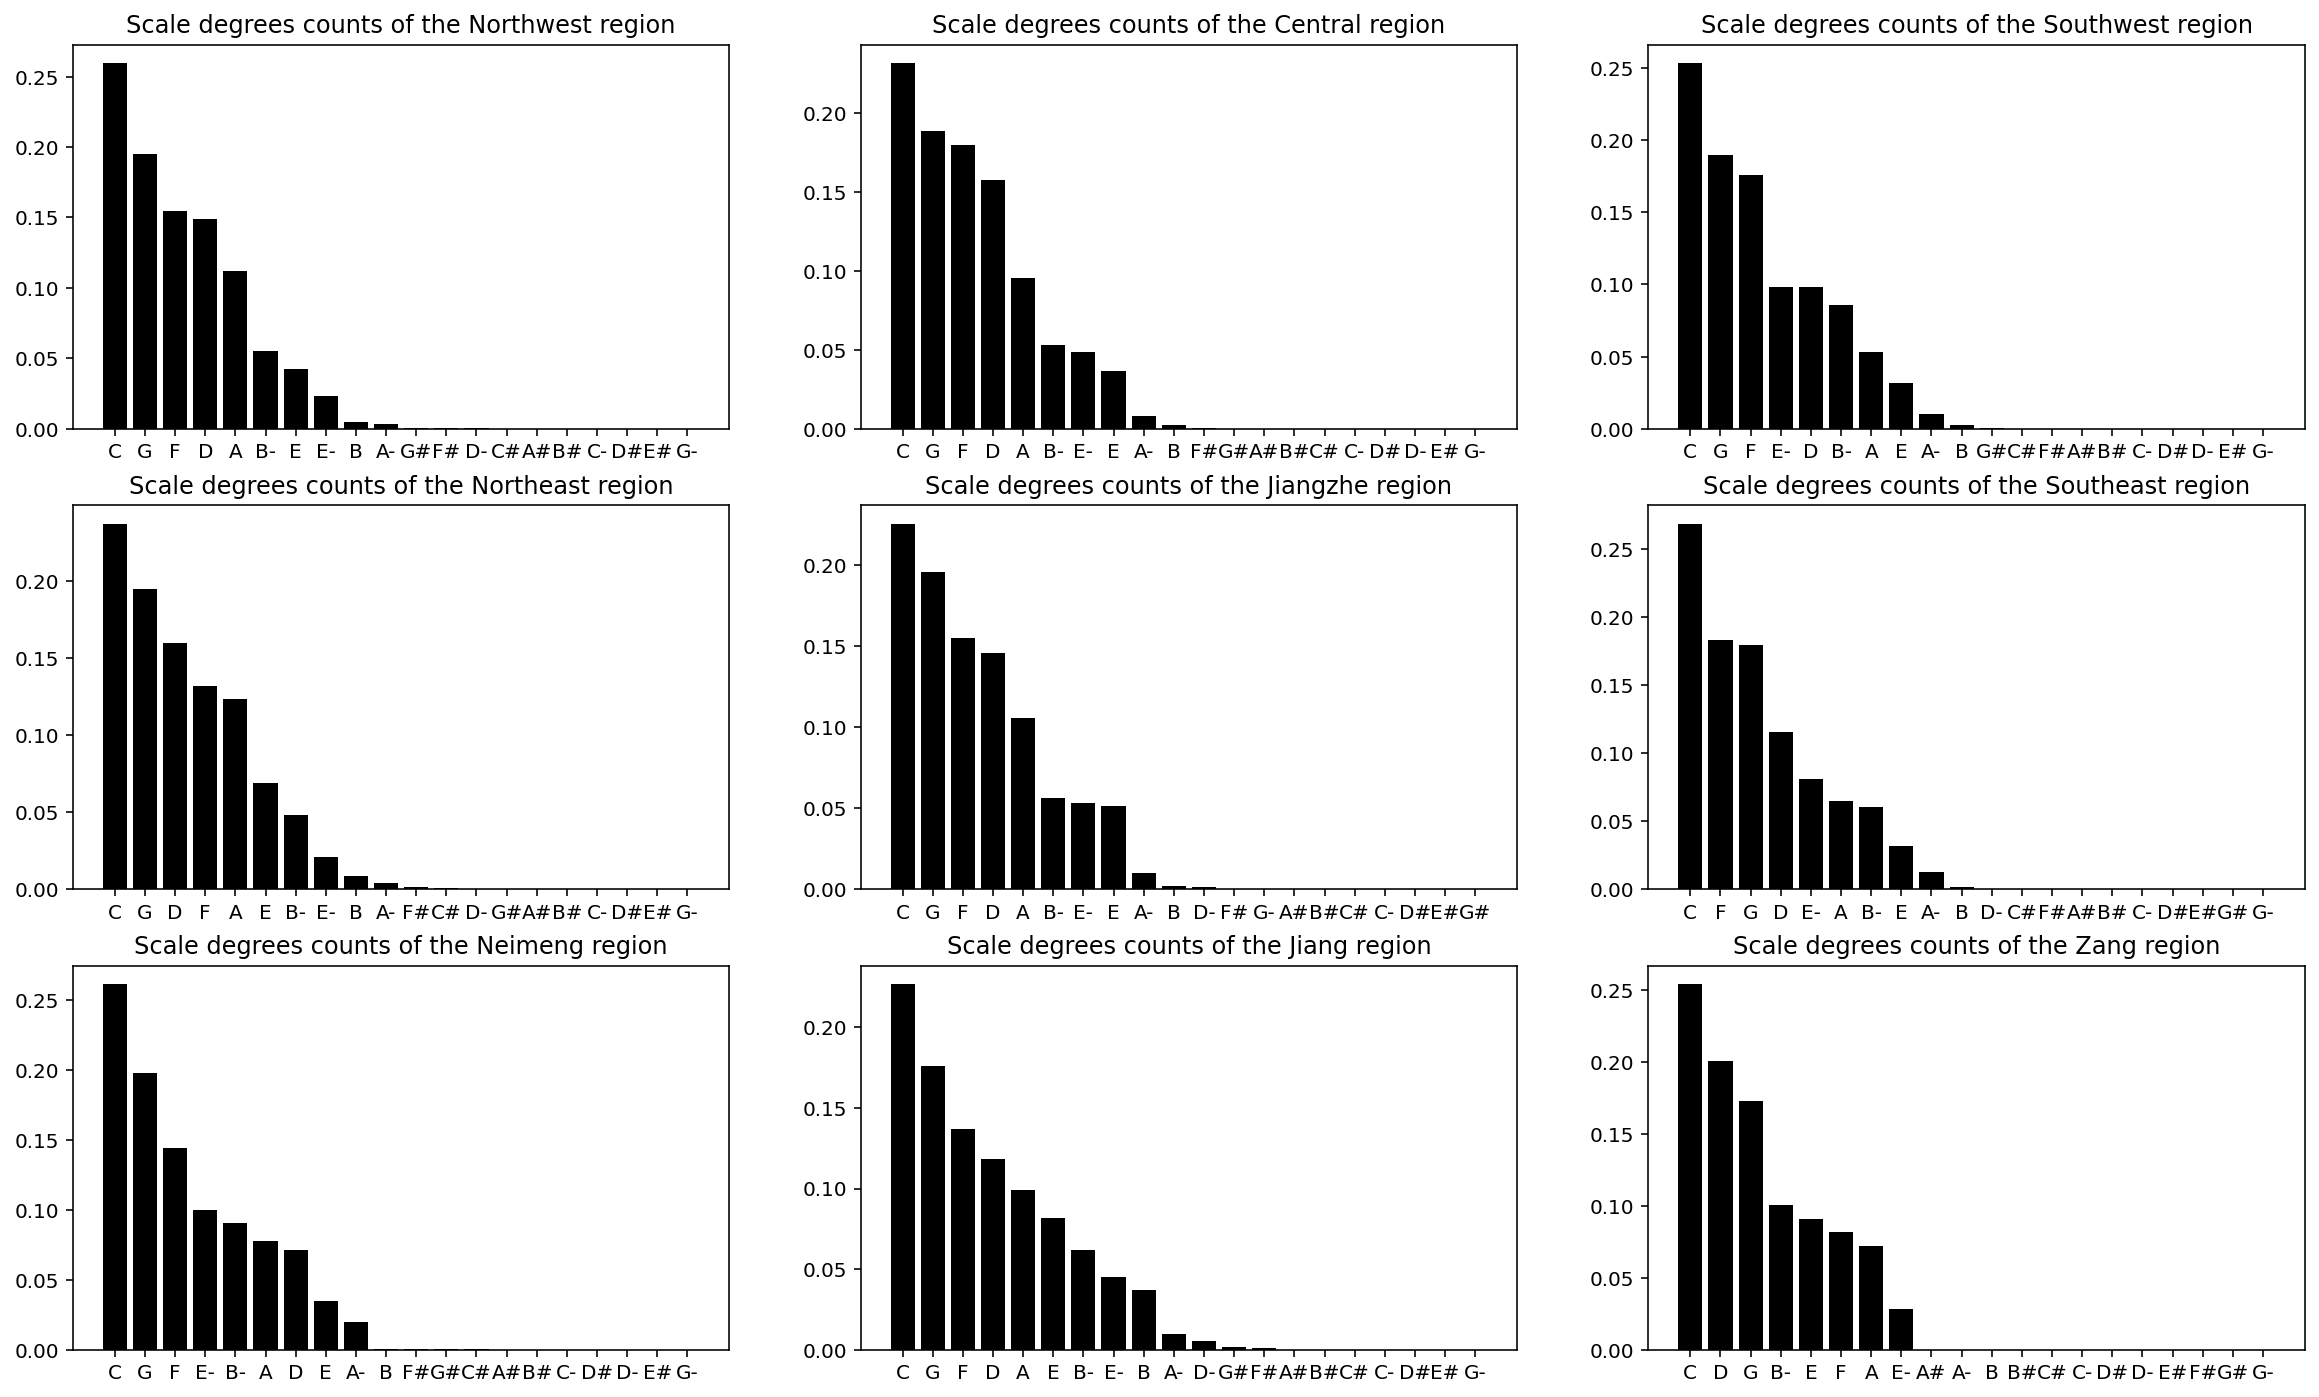

In [25]:
plot_region_stat_counts(region_scaledegrees_stat, pitchclasses_defcount, title="Scale degrees counts of the {} region")

The results of this analysis shows a tonal hierachy very similar to one computed by Huron on Germanic Folk Songs (*Sweet Anticipation*, Huron 2006). It is not surprising to find the tonic as the most frequent scale degree since it is part of how it was defined. However, as the dominant, subdominant and second are the next most frequent scale degrees in all regions, this analysis shows great similarity between regions and thus goes against our initial hypothesis.

#### Frequencies with metrical structure

A simple count of scale degrees does not account for the metrical structure. Indeed, the scale degree of the first note of the piece does not have the same importance as the second one. Therefore, a weight corresponding to the product of the duration and beat strength is assigned to each scale degree. The following helper function plots histograms of the given statistics using this weighted method.

In [27]:
def plot_region_stat_met(stat, defcount=None, figsize=(20,10), nrows=3, ncols=3, log_y=False, sort=True, title="{}"):
    plt.rcParams["figure.figsize"] = figsize
    region_counts = {}
    fig, axarr = plt.subplots(nrows, ncols)

    for gloc ,ax in zip(stat, axarr.flat):

        counter = {}
        for i in range(len(stat[gloc])):
            if math.isnan(region_beat_strengths_stat[gloc][i]) or math.isnan(region_durations_stat[gloc][i]):
                continue
            if not stat[gloc][i] in counter.keys():
                counter[stat[gloc][i]] = region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]
            else:
                counter[stat[gloc][i]] +=  region_durations_stat[gloc][i]*region_beat_strengths_stat[gloc][i]

        fractions = {i:counter[i] / len(stat[gloc]) for i in counter}
        if defcount is not None:
            fractions = {**defcount, **fractions}
        region_counts[gloc] = sorted(fractions.items(), key=lambda pair: -pair[1]) if sort else fractions.items()
        x, y = zip(*region_counts[gloc])
        ax.bar(x, y, color='black')
        if log_y:
            ax.set_yscale('log')
        ax.set_title(title.format(gloc))

This function can now be used with the scale degrees statistics.

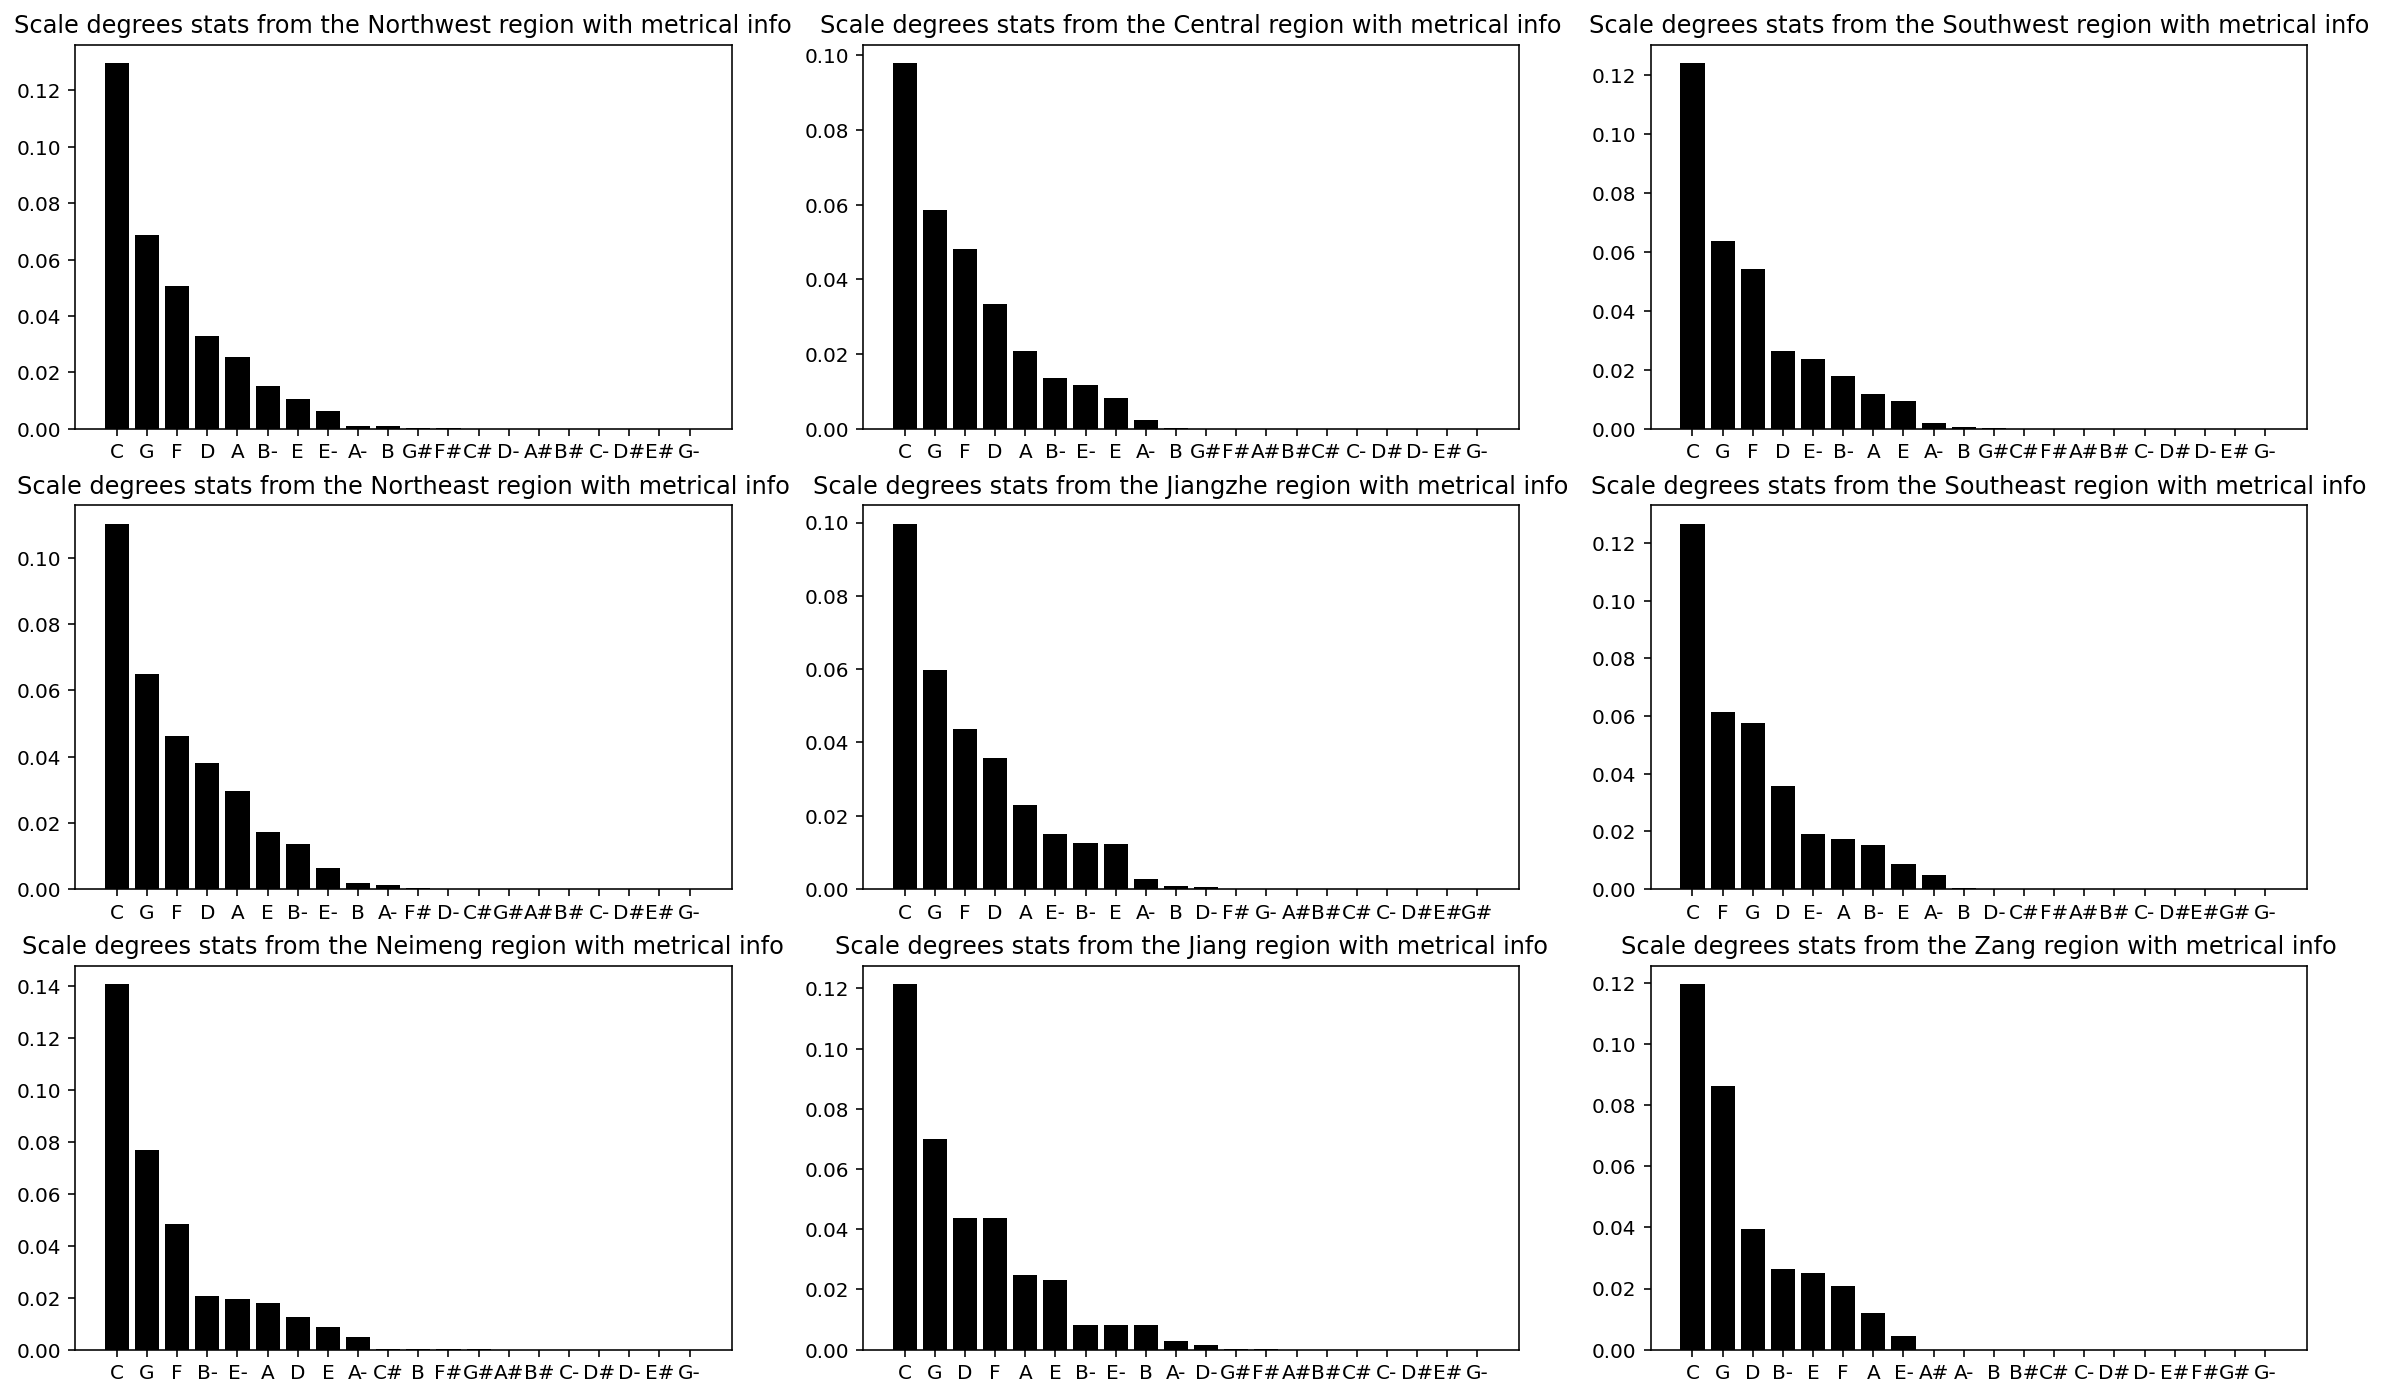

In [29]:
plot_region_stat_met(region_scaledegrees_stat, pitchclasses_defcount, title="Scale degrees stats from the {} region with metrical info", figsize=(20,12))

The results of this analysis are similar to the previous one. Namely, the dominant, subdominant and second are again the most prevalent scale degrees after the tonic. Therefore such analysises of the distributions of scale degrees only refute our hypothesis.

### Scale degrees transitions

While the frequencies of scale degrees only show regional similarities, the transitions between them may reveal differences. Indeed, such an analysis may reveal for example that in one region the tonic most often translates to the dominant, while in another region it most often goes to the second.

To do so, we first iterate over all pieces of all regions to count the number of transitions in each region. A dictionary is created to store this count, for which the keys correspond to the regions' names and the values are nested dictionaries. These nested dictionaries have the starting scale degrees as keys and their values are dictionaries containing the landing scale degrees as keys and the count of such transition as values.

As an example is more telling than a lengthy explanation, here is an example of the start of this dictionary containing the number of transitions from C in the Northwest region:
```python
{'Northwest': 
    {'C': 
       {'G': 1572,
       'C': 2904,
       'F': 1581,
       'B-': 1507,
       'E-': 376,
       'D': 2469,
       'A': 1909,
       'G#': 2,
       'E': 329,
       'B': 119,
       'A-': 21,
       'D-': 5},
     ...
    }
}
```

In [31]:
pitchclass_transition_absolute = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for pitchclass in row["pitchclasses_transposed"]:
        if prev_pitchclass is not None:
            if prev_pitchclass not in pitchclass_transition_absolute[region]:
                pitchclass_transition_absolute[region][prev_pitchclass] = {}
            if pitchclass not in  pitchclass_transition_absolute[region][prev_pitchclass]:
                pitchclass_transition_absolute[region][prev_pitchclass][pitchclass] = 1
            else:
                pitchclass_transition_absolute[region][prev_pitchclass][pitchclass] += 1
        prev_pitchclass = pitchclass

These transitions can then be plotted as heatmaps. To create them, we first convert the transition counts from a dictionary to a `DataFrame` and use it to plot the heatmap.

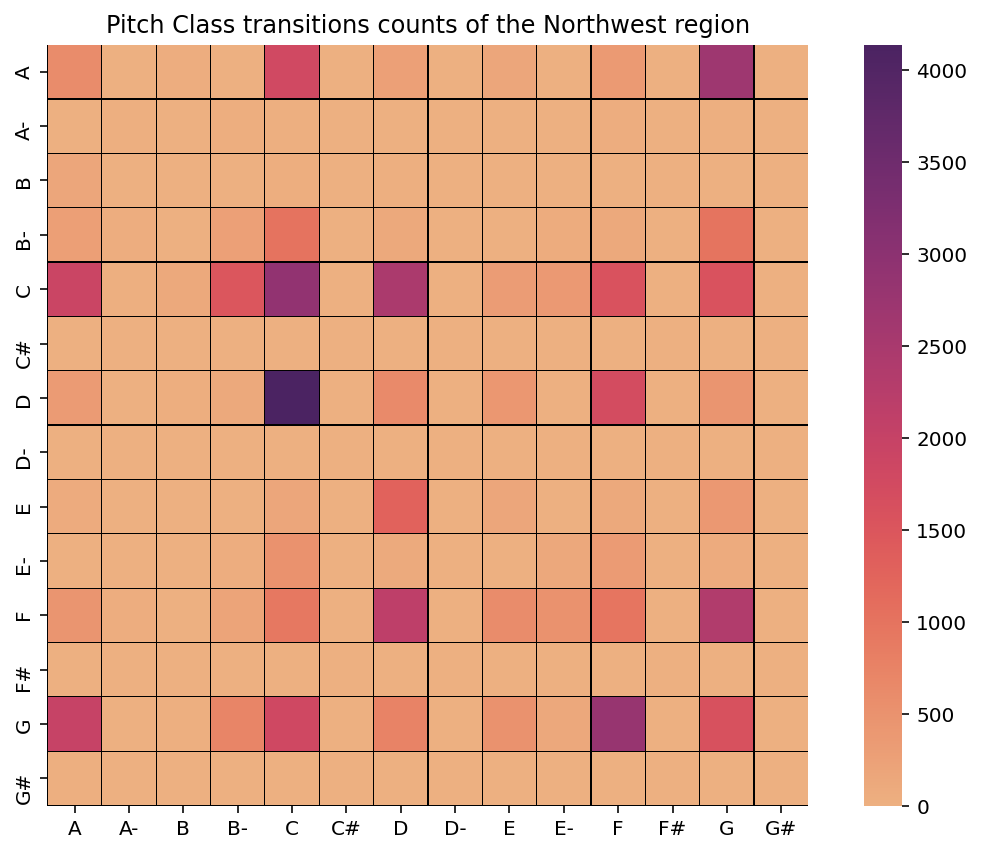

----------------------------------------------------------------------------------------------------


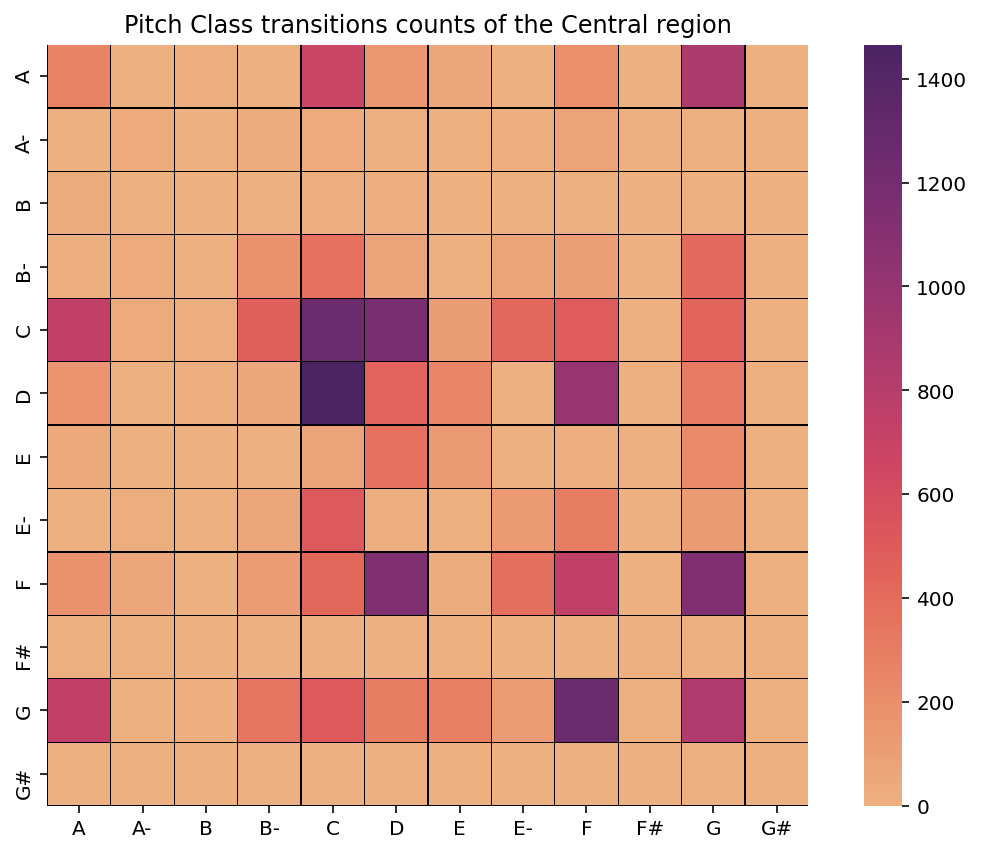

----------------------------------------------------------------------------------------------------


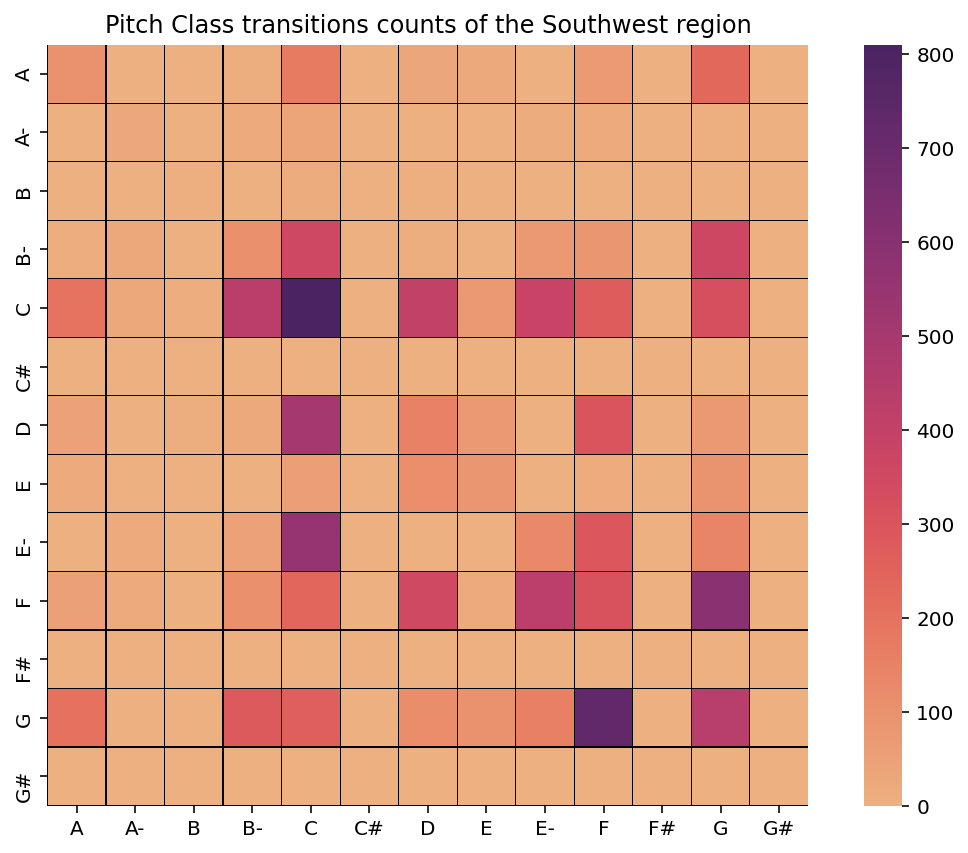

----------------------------------------------------------------------------------------------------


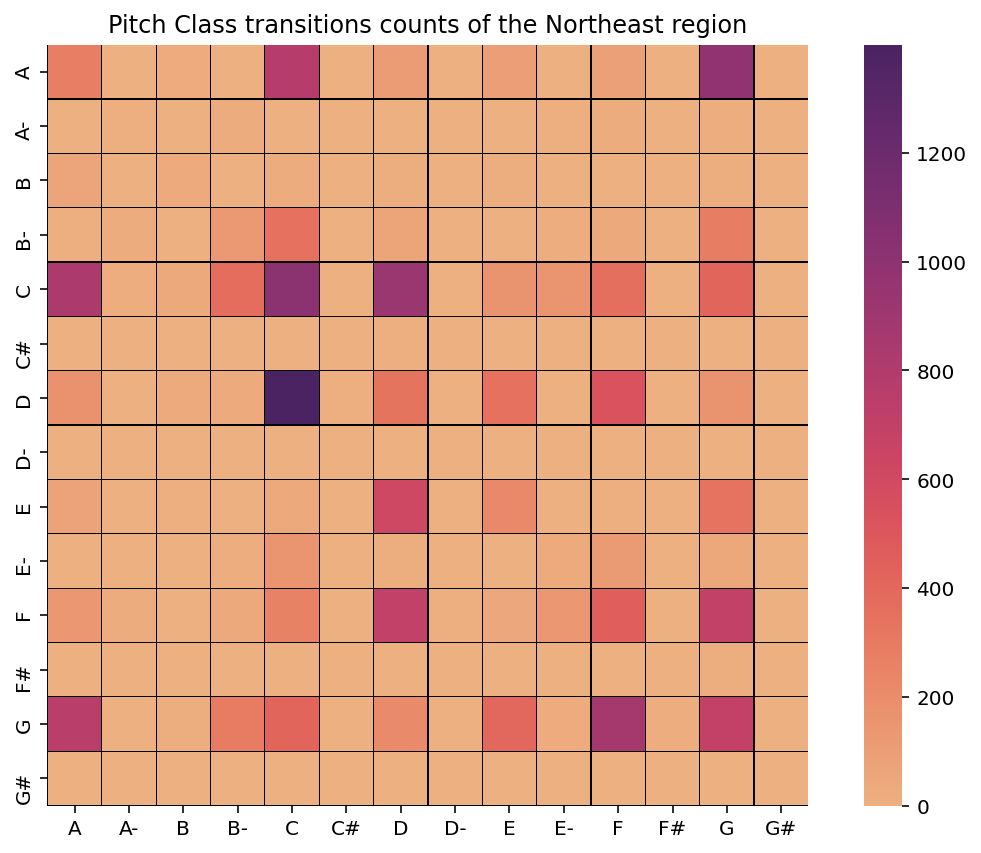

----------------------------------------------------------------------------------------------------


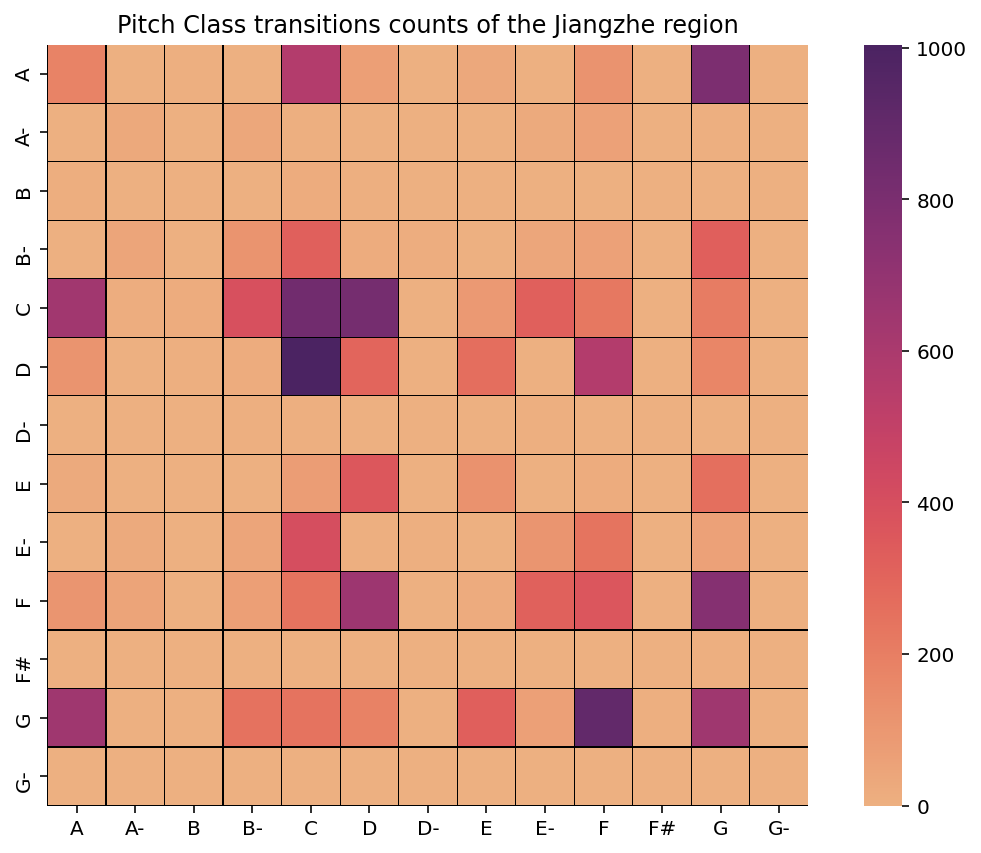

----------------------------------------------------------------------------------------------------


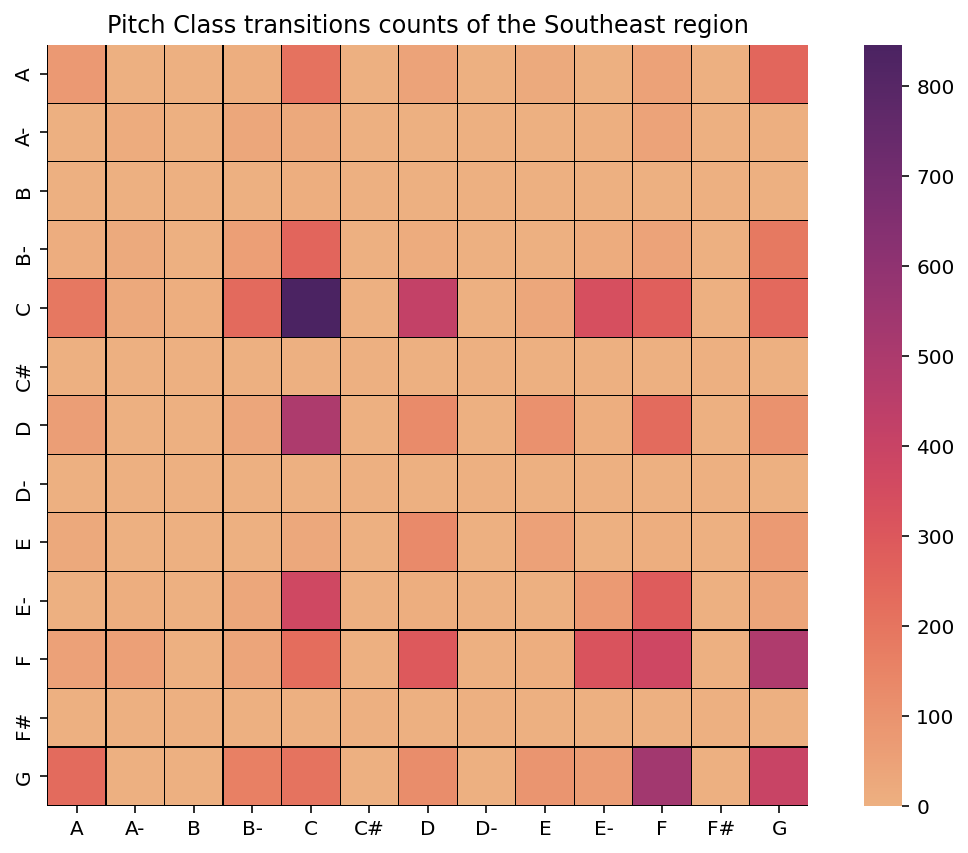

----------------------------------------------------------------------------------------------------


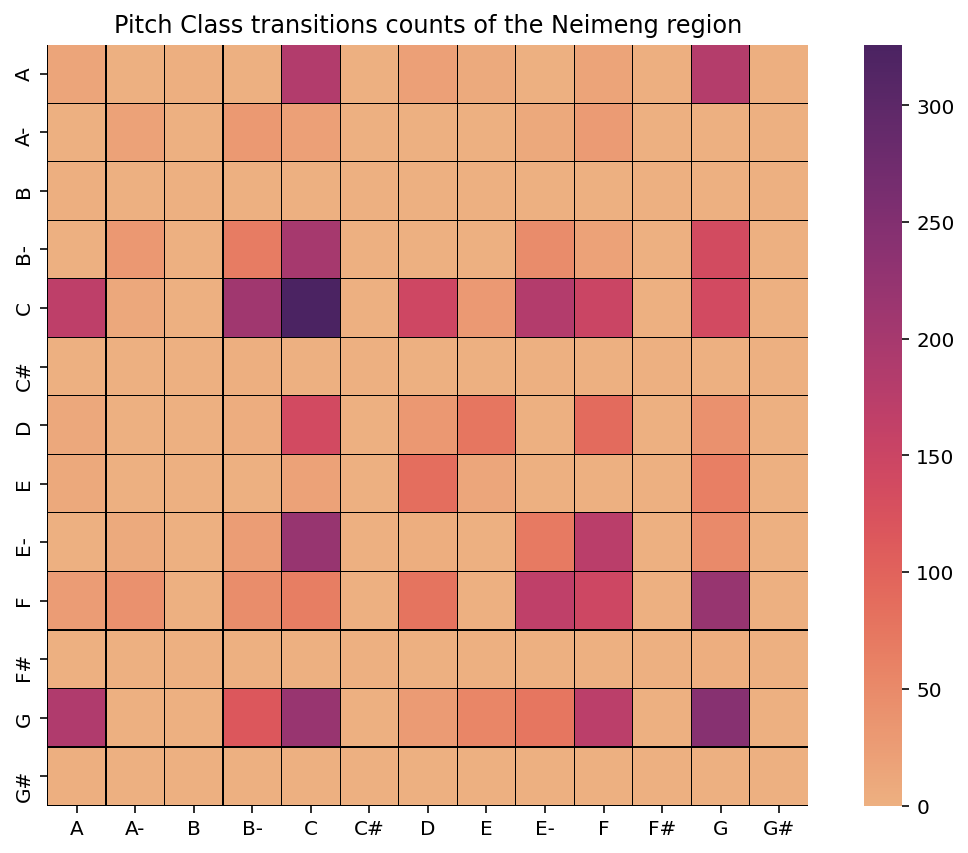

----------------------------------------------------------------------------------------------------


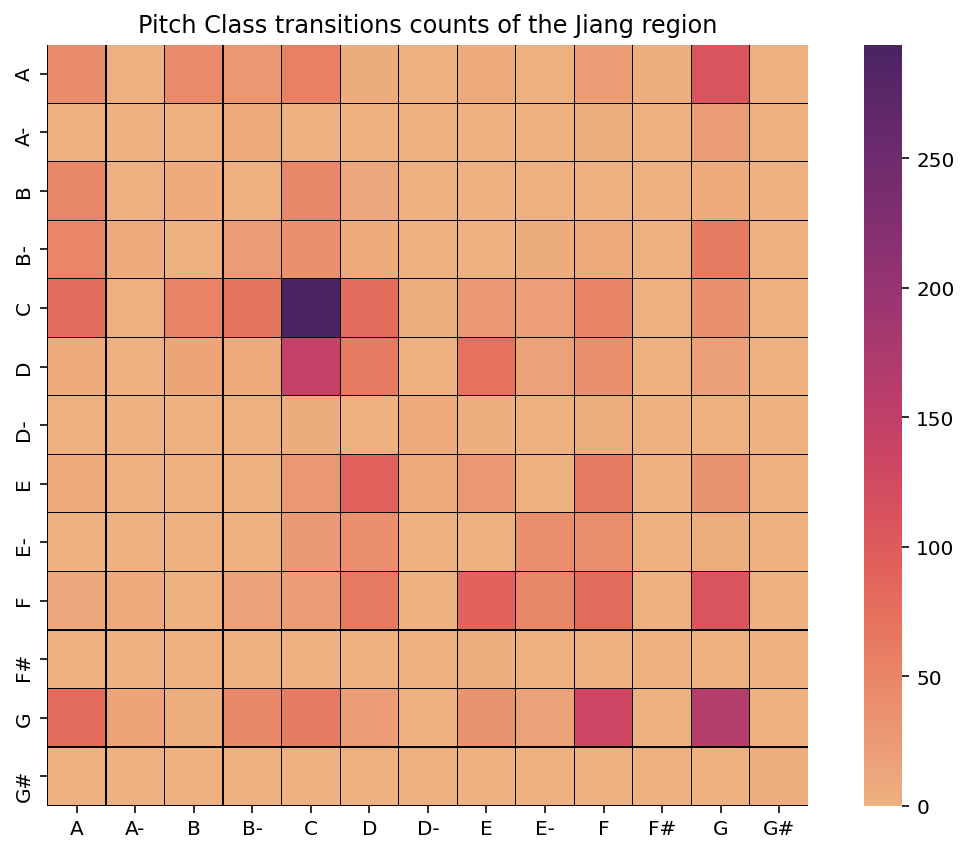

----------------------------------------------------------------------------------------------------


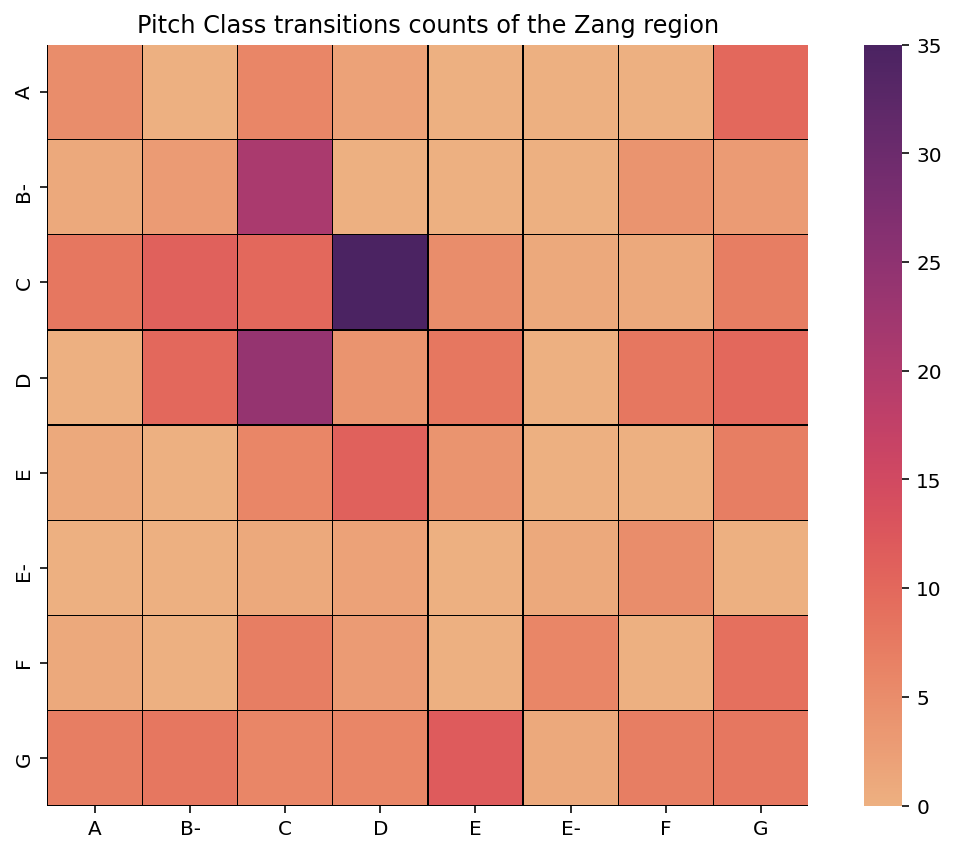

----------------------------------------------------------------------------------------------------


In [32]:
def sort_dict(item):
    # function to sort a nested dictionary based on key
    # credits: https://gist.github.com/gyli/f60f0374defc383aa098d44cfbd318eb
    return {k: sort_dict(v) if isinstance(v, dict) else v for k, v in sorted(item.items())}

plt.rcParams["figure.figsize"] = (10, 7)
colormap = sns.color_palette("flare", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition_absolute[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transitions counts of the {} region".format(gloc))
    plt.show()
    
    print("--"*50)

INSERT COMMENT ON THESE TRANSITIONS

### Intervals

While the distribution of intervals are technically visible on the the plots above, it is more convenient to display them as histograms. This can be easily done by using the same helper function as for the scale degrees distributions, only using the intervals statistics this time.

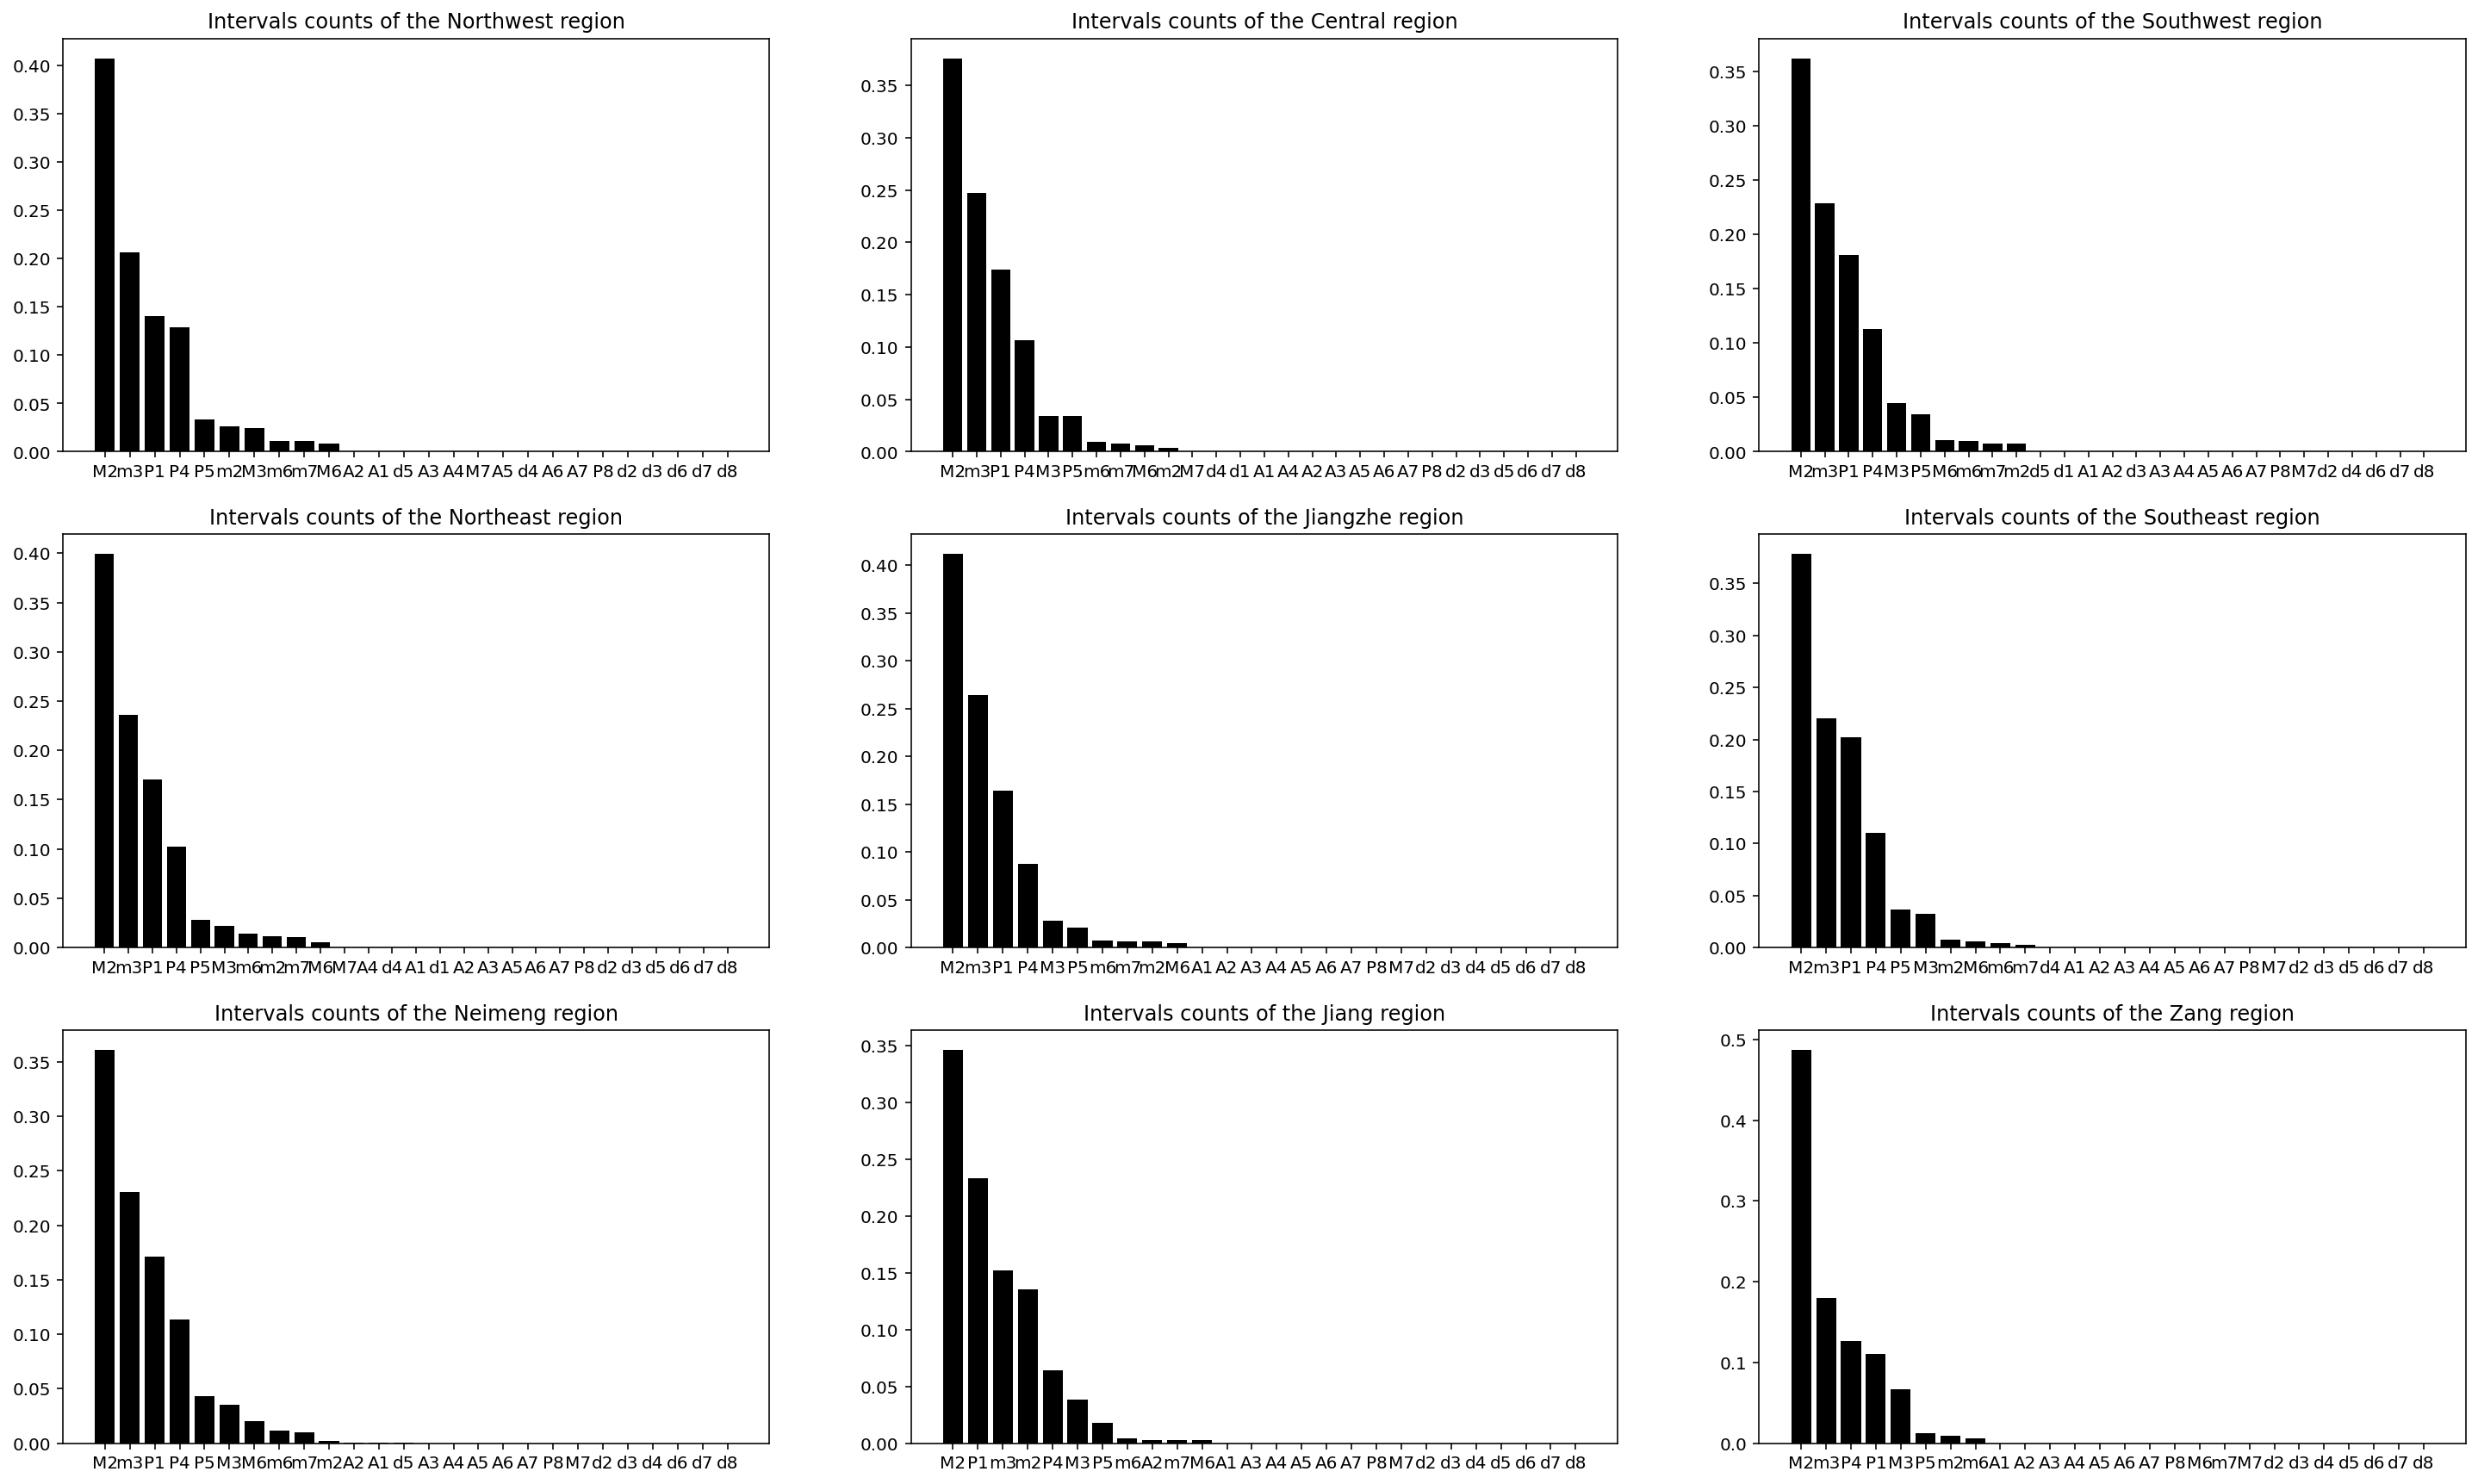

In [33]:
plot_region_stat_counts(region_intervals_stat, intervals_defcount, log_y=False, figsize=(25,15), title="Intervals counts of the {} region")

This analysis shows a great similarity between all regions as the major second is by far the most used intervals and, except for a single region, it is followed by the minor third. Moreover, the perfect unison most often comes as the third most used interval.

# Transitions using local beat strengths

In [22]:
import numpy as np
from copy import deepcopy

In [44]:
pitchclass_transition_localbs = {geo_region: {} for geo_region in geo_divisions}
for index, row in CFS_full.iterrows():
    prev_pitchclass = None
    region = row["geo_division"]
    for i in range(len(row["pitchclasses_transposed"])):
        curr_bs = row["beat_strengths"][i]
        if prev_pitchclass is not None:
            if curr_bs > prev_bs:
                curr_node_name = row["pitchclasses_transposed"][i] + "_S"
                prev_node_name = prev_pitchclass + "_W"
            elif curr_bs < prev_bs:
                curr_node_name = row["pitchclasses_transposed"][i] + "_W"
                prev_node_name = prev_pitchclass + "_S"
            else:
                curr_node_name = row["pitchclasses_transposed"][i] + "_E"
                prev_node_name = prev_pitchclass + "_E"
            
            if prev_node_name not in pitchclass_transition_localbs[region]:
                pitchclass_transition_localbs[region][prev_node_name] = {}
            
            if curr_node_name not in  pitchclass_transition_localbs[region][prev_node_name]:
                pitchclass_transition_localbs[region][prev_node_name][curr_node_name] = 1
            else:
                pitchclass_transition_localbs[region][prev_node_name][curr_node_name] += 1
        prev_pitchclass = row["pitchclasses_transposed"][i]
        prev_bs = curr_bs

In [45]:
cut_off_prob = 0
normalised_pitchclass_transition_localbs = deepcopy(pitchclass_transition_localbs)       
for geo_region in normalised_pitchclass_transition_localbs:
    for start_node in normalised_pitchclass_transition_localbs[geo_region]:
        total_count_at_node = sum(normalised_pitchclass_transition_localbs[geo_region][start_node].values())
        temp_dict = {}
        for end_node in normalised_pitchclass_transition_localbs[geo_region][start_node]:
            normalised_prob = (normalised_pitchclass_transition_localbs[geo_region][start_node][end_node]/total_count_at_node)
            if normalised_prob > cut_off_prob:
                temp_dict[end_node] = normalised_prob
        normalised_pitchclass_transition_localbs[geo_region][start_node] = temp_dict

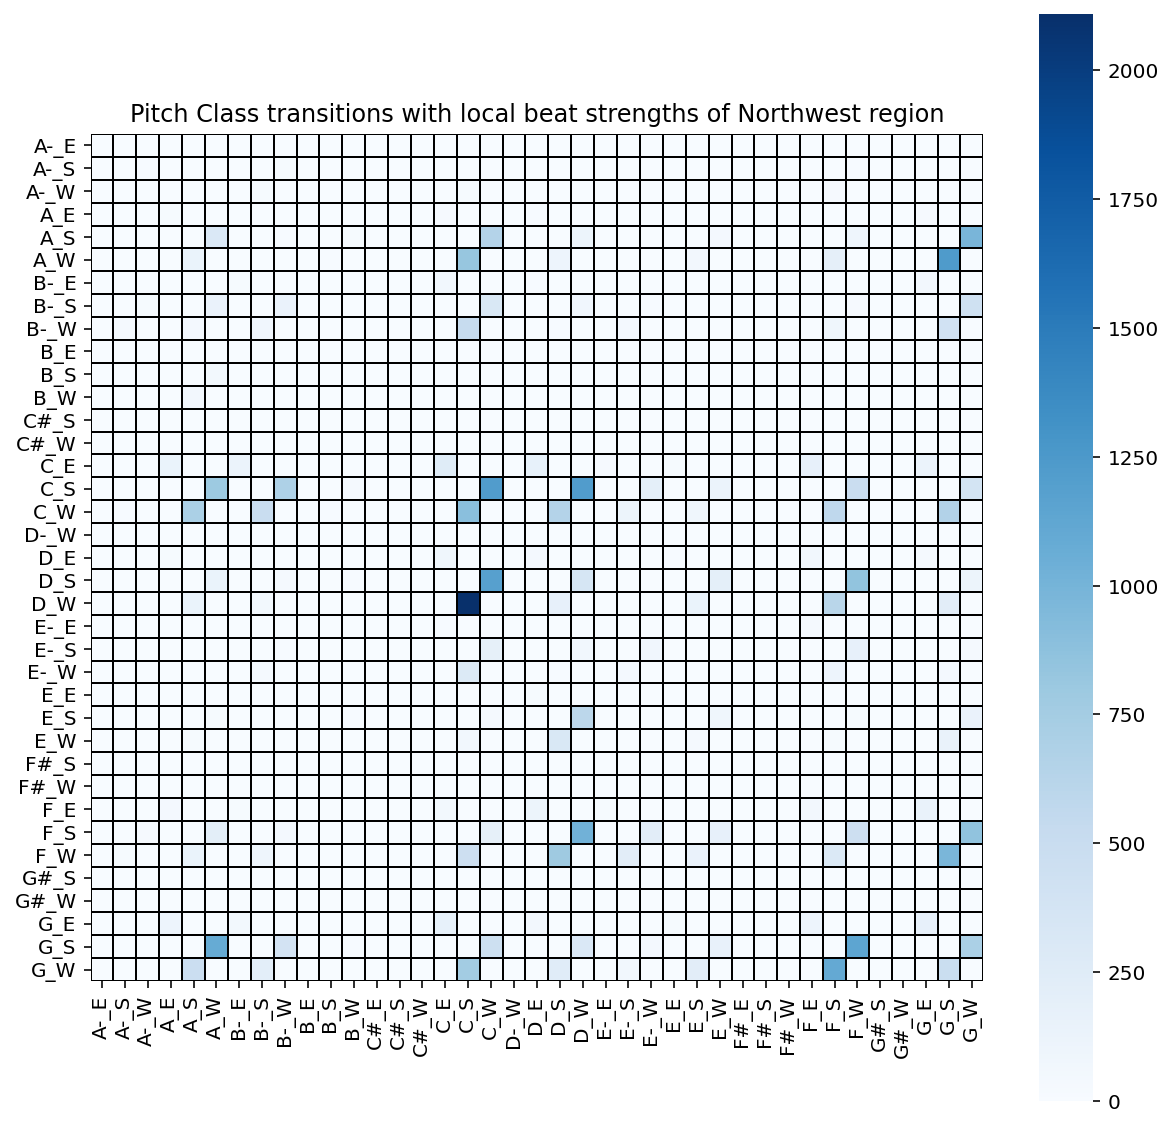

----------------------------------------------------------------------------------------------------


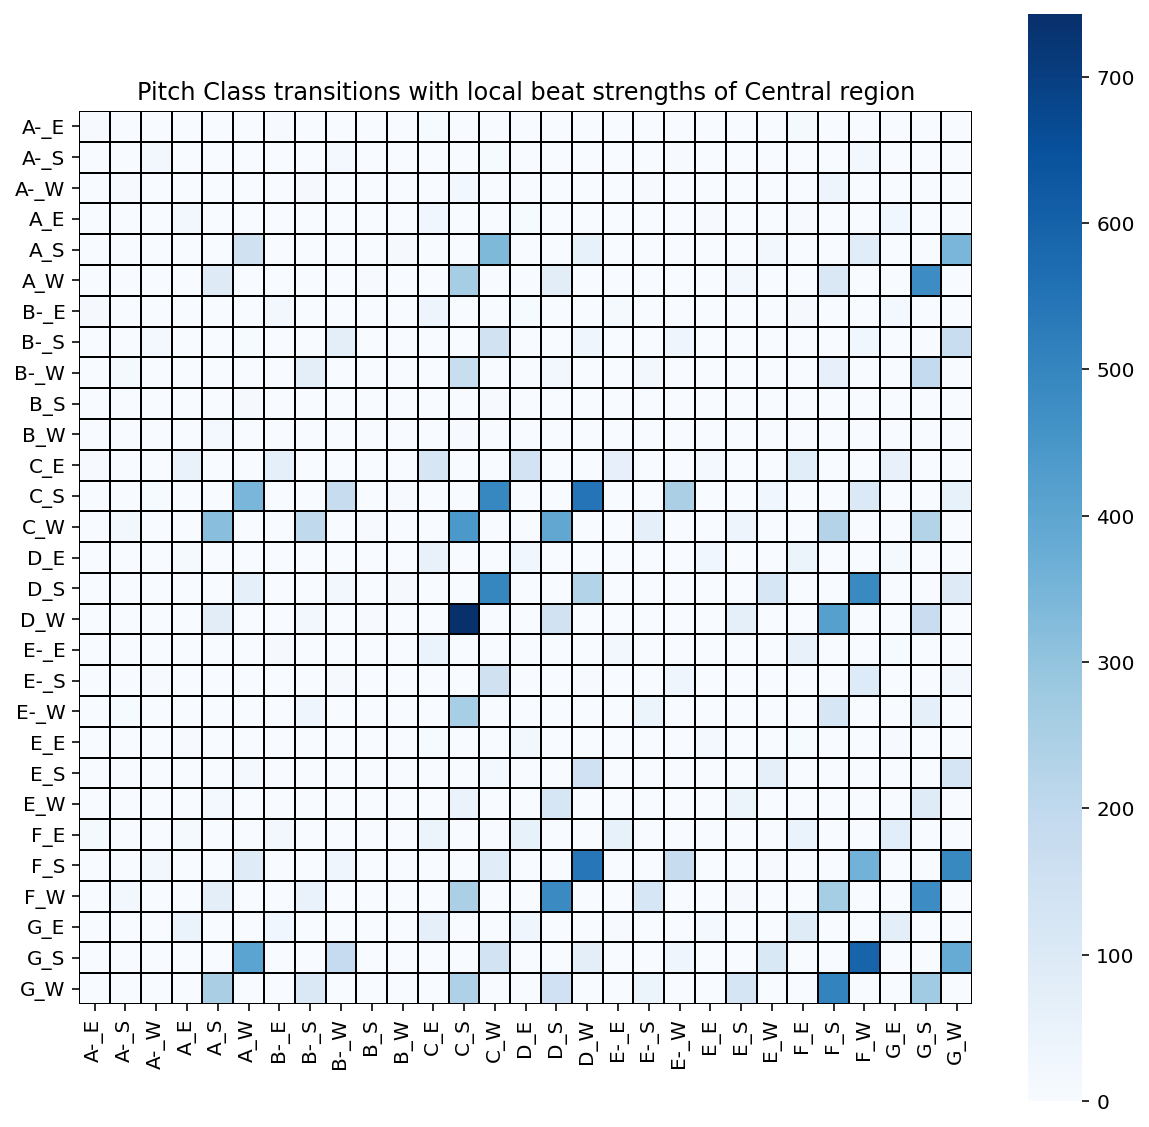

----------------------------------------------------------------------------------------------------


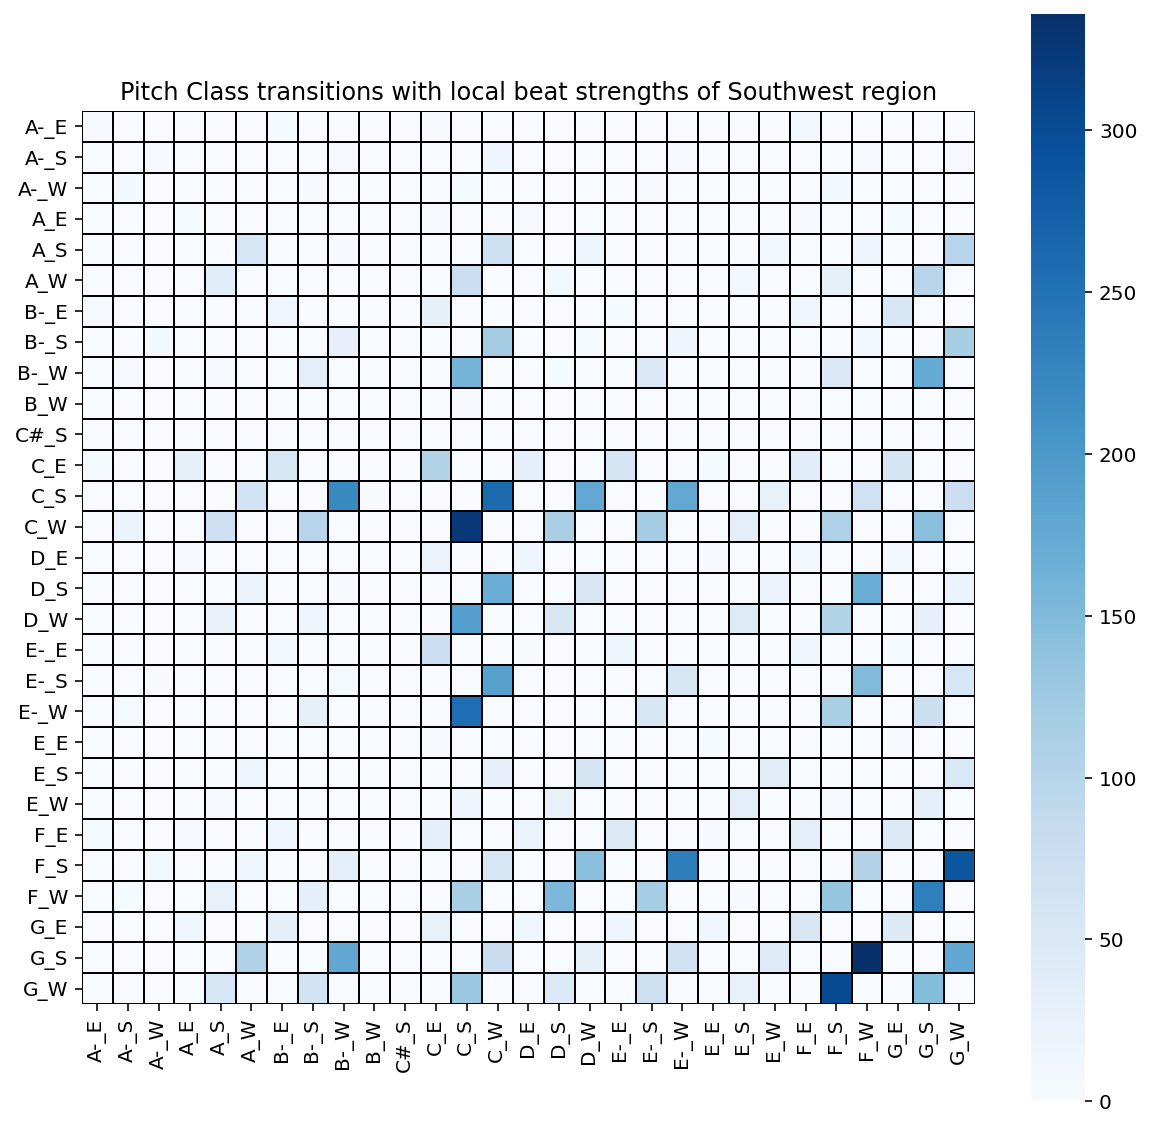

----------------------------------------------------------------------------------------------------


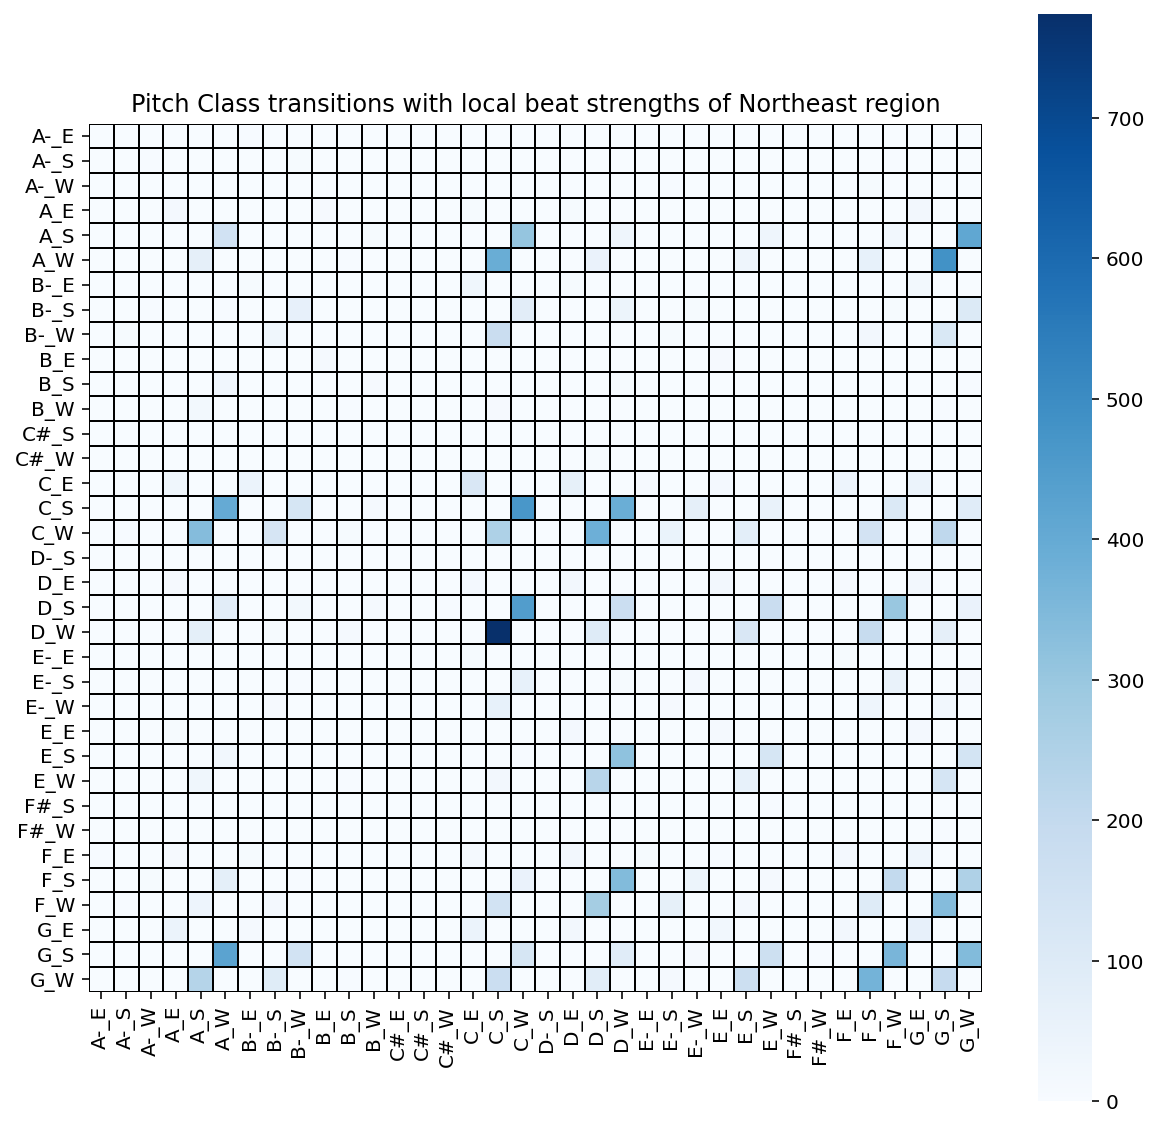

----------------------------------------------------------------------------------------------------


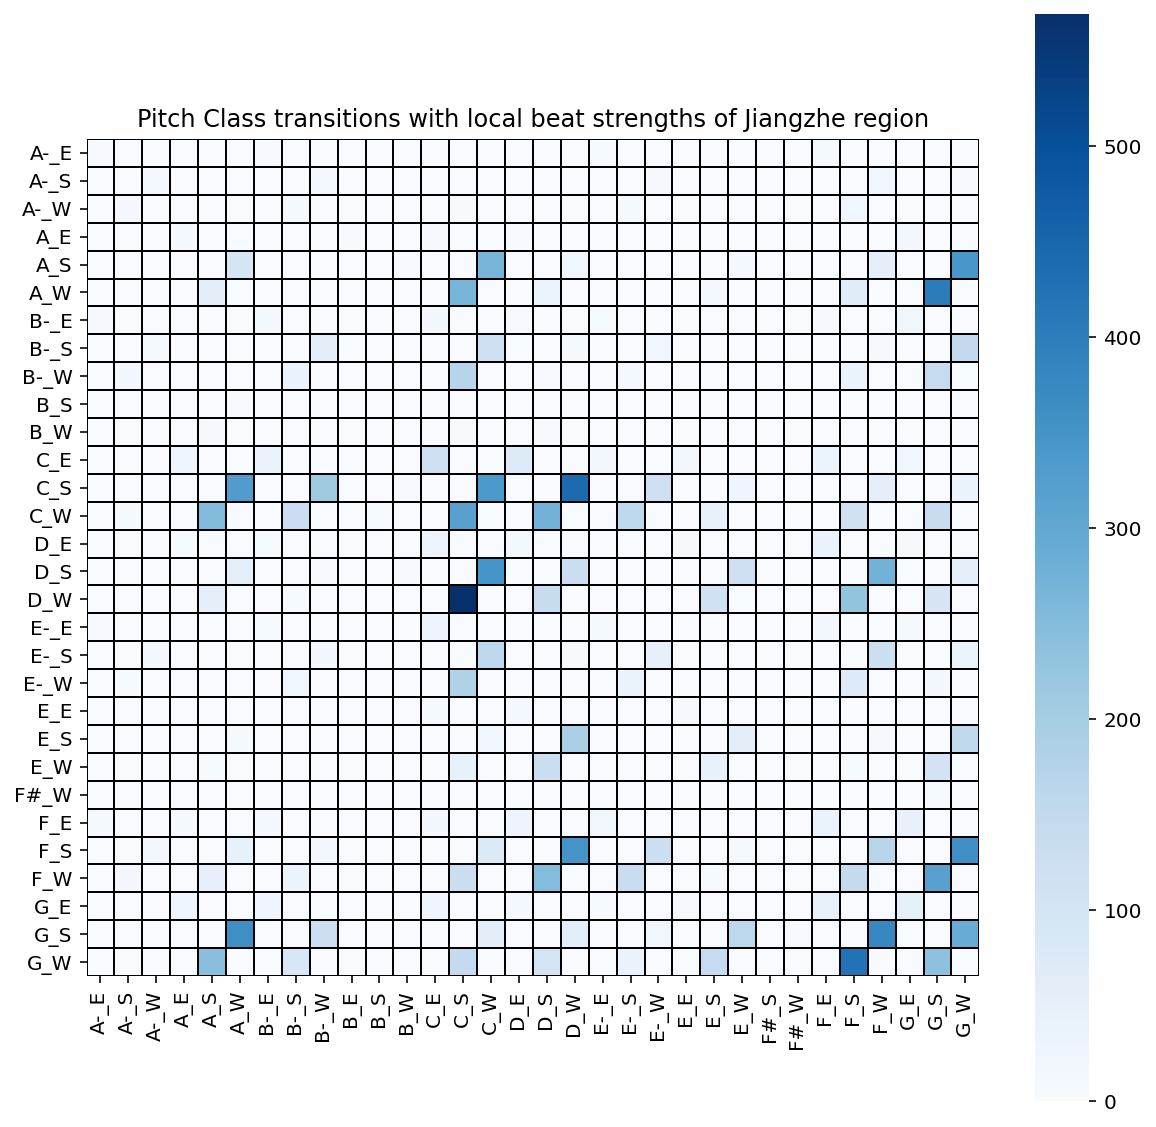

----------------------------------------------------------------------------------------------------


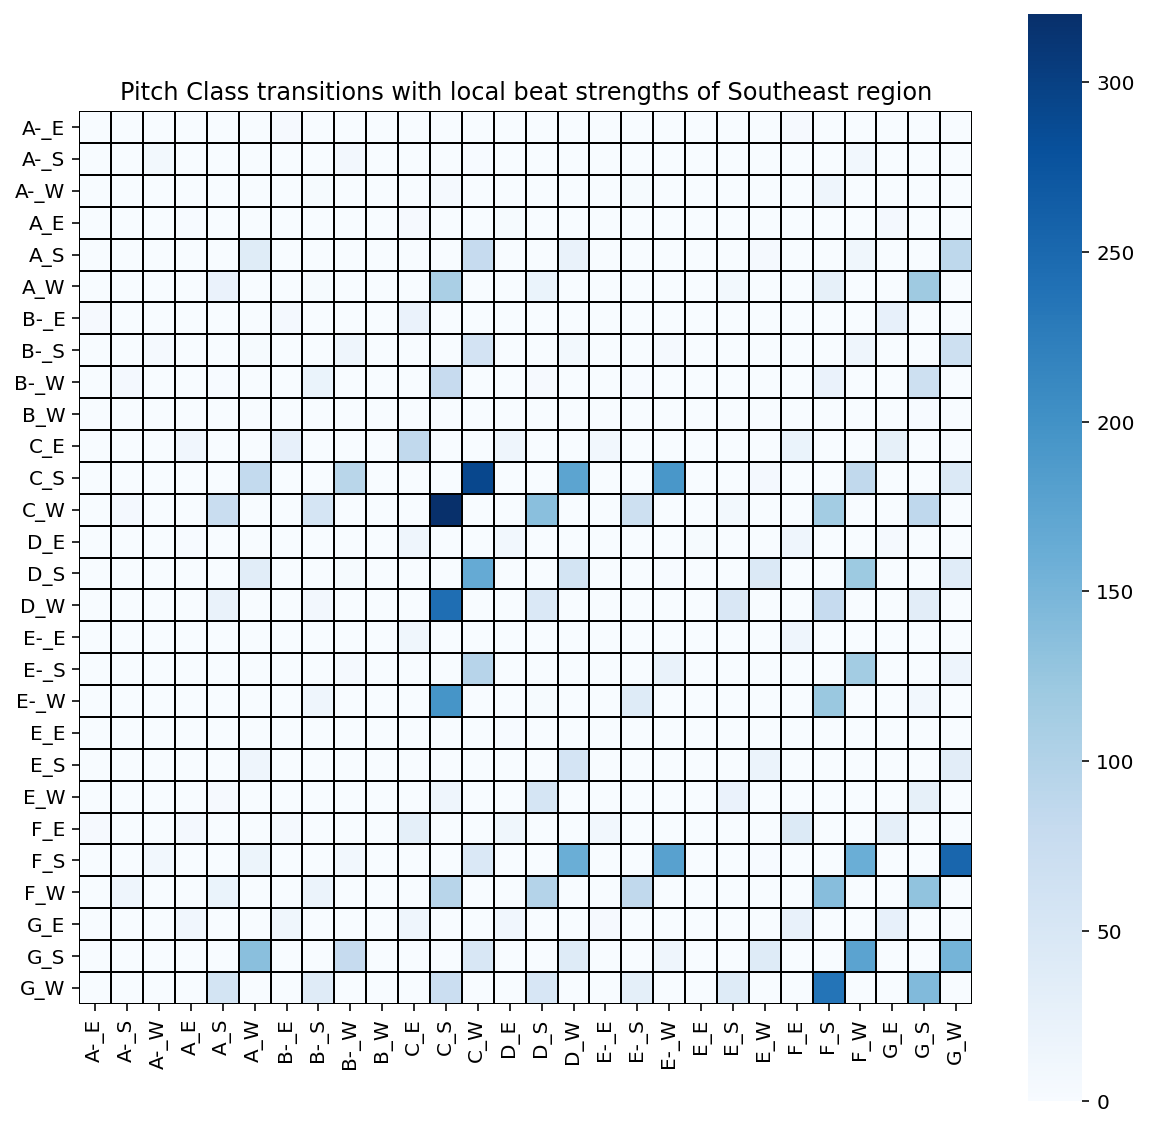

----------------------------------------------------------------------------------------------------


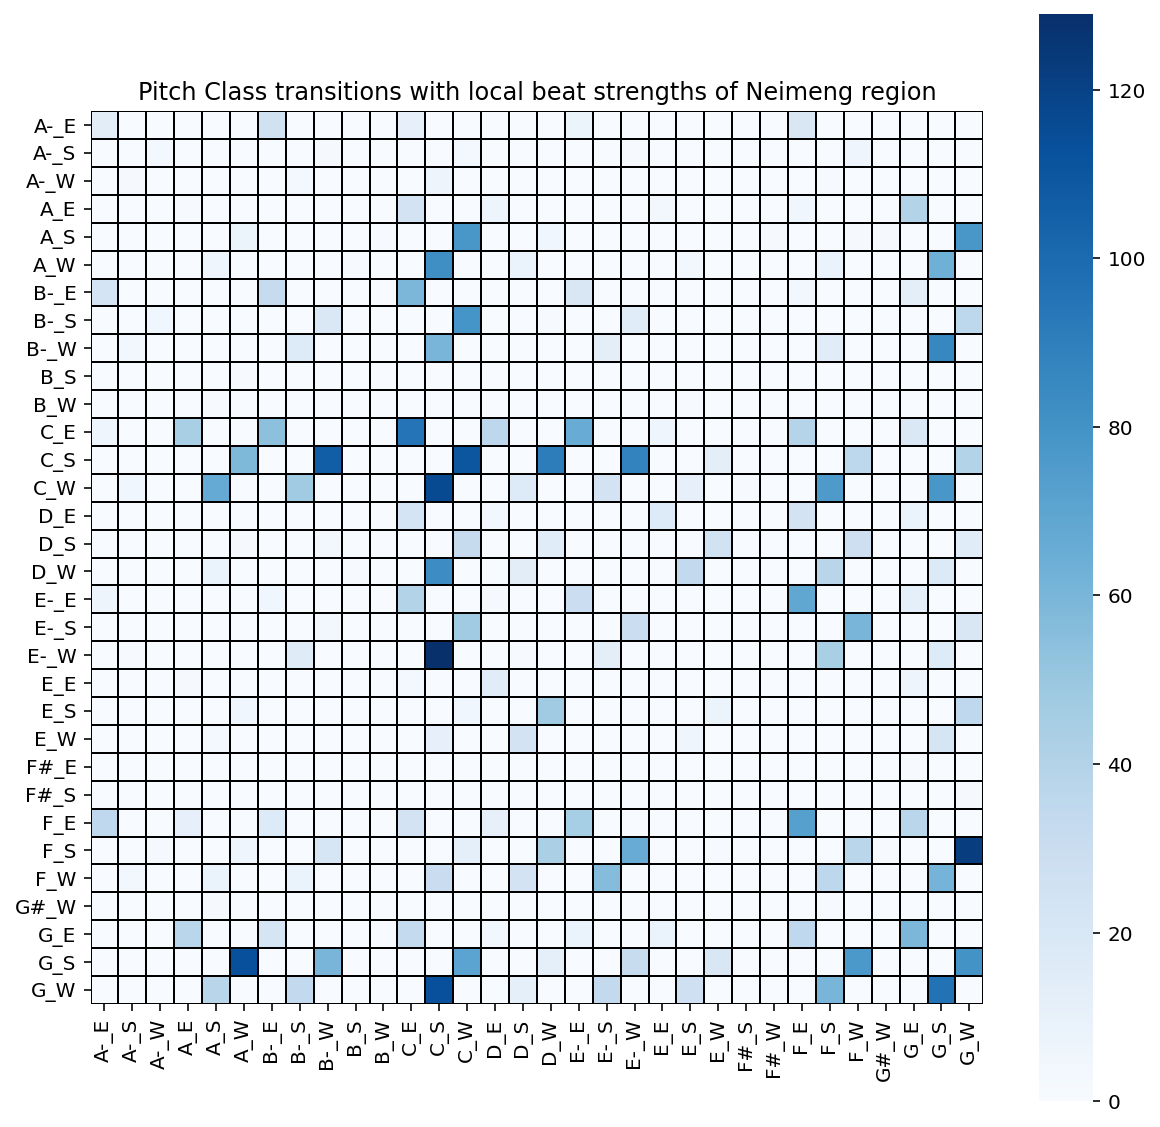

----------------------------------------------------------------------------------------------------


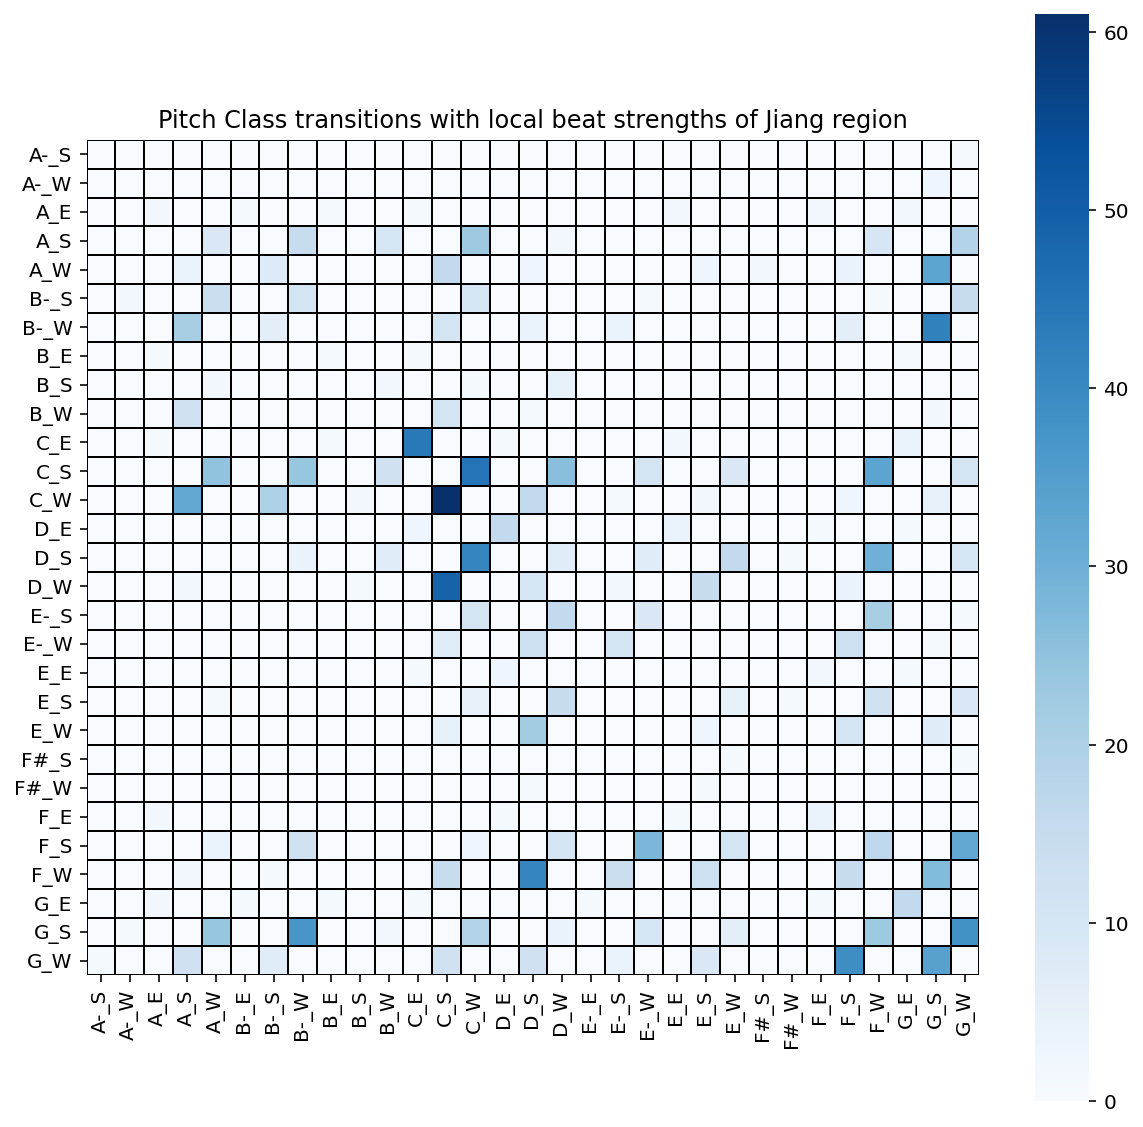

----------------------------------------------------------------------------------------------------


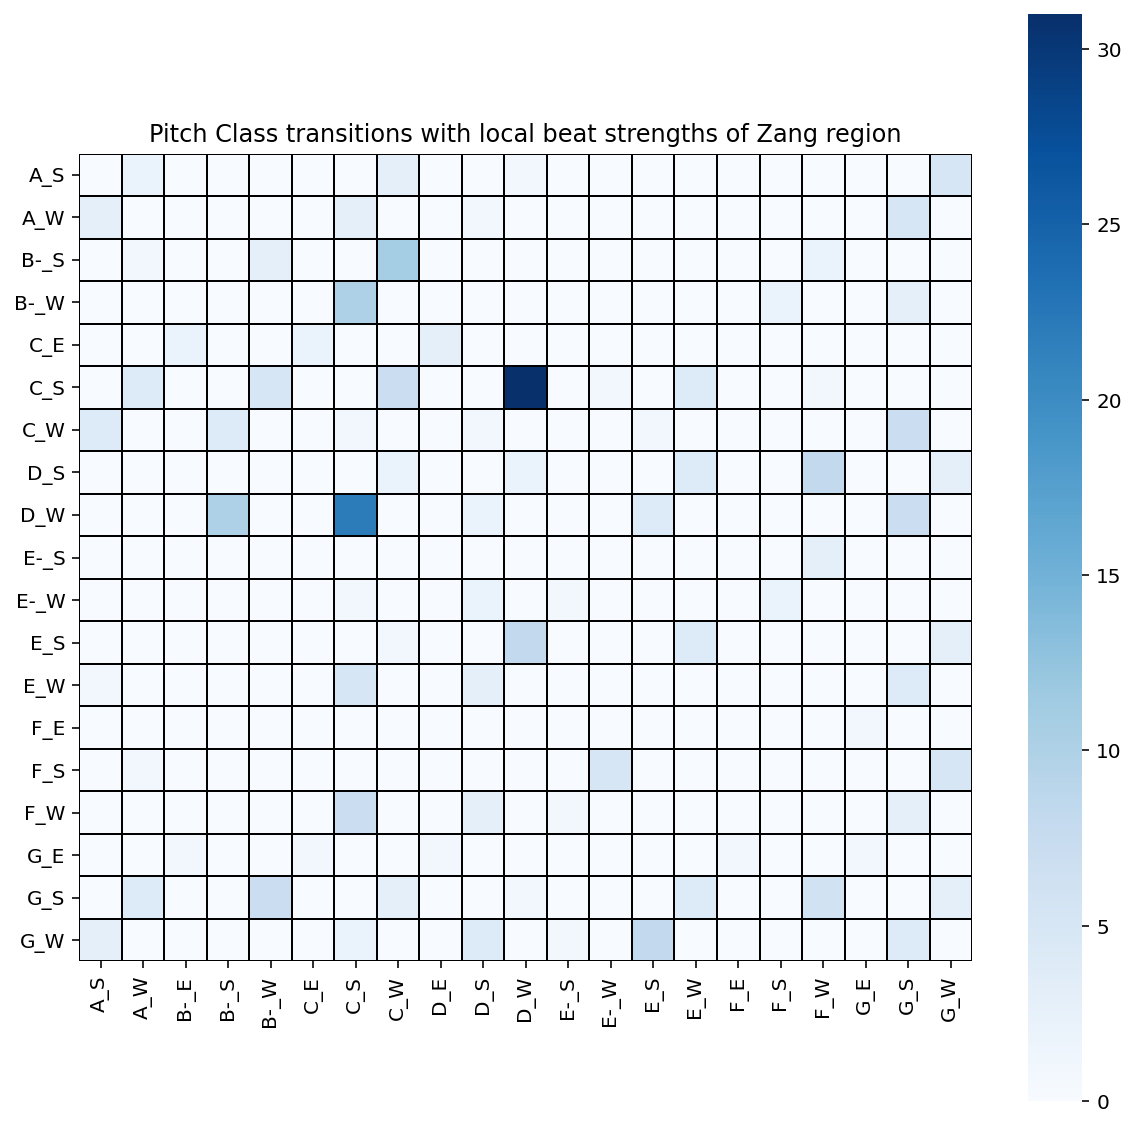

----------------------------------------------------------------------------------------------------


In [47]:
plt.rcParams["figure.figsize"] = (10, 10)
colormap = sns.color_palette("Blues", as_cmap=True)
for gloc in geo_divisions:
    fig, axes = plt.subplots(1,1)
    
    sorted_probs = sort_dict(pitchclass_transition_localbs[gloc])
    gloc_matrix = pd.DataFrame.from_dict(sorted_probs).T.fillna(0)
    gloc_matrix = gloc_matrix.reindex(sorted(gloc_matrix.columns), axis=1)
    
    ax1 = sns.heatmap(gloc_matrix, cmap= colormap, square=True, linecolor='black', linewidths=0.1, vmin=0)
    axes = ax1
    ax1.set_title("Pitch Class transitions with local beat strengths of {} region".format(gloc))
    plt.show()
    
    print("--"*50)

### Scale degree flexibility

In *Sweet Anticipation*, Huron defines the flexibility of a scale degree as the "uncertainty that attends the continuation following a given pitch". For example, if a pitch is always followed by the same one, its uncertainty will be null. However, if it is equally probable to be followed by any pitch, then its uncertainty is maximal.

This measure of uncertainty can be computed using the Shannon-Weaver equation for the entropy, where the binary entropy $H$ of a random variable $X$ is computed as $H(X) = -\sum_{i=1}^{n}P(X_i)\log_2(P(X_i))$. In this context, $X$ will be the random variable defining the probability that a certain pitch translates to another one. This variable is called `pitchclass_transition_probability` in the code below. These probabilities can be easily computed by dividing the transitions counts computed earlier by the total amount of transitions.

In [35]:
pitchclass_transition_probability = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition_absolute.items():
    for start_note, transition in transitions.items():
        pitchclass_transition_probability[region][start_note] = {}
        for landing_note, count in transition.items():
            pitchclass_transition_probability[region][start_note][landing_note] = count/sum(transition.values())

We can now use the definition of the entropy to compute it from these probabilities.

In [49]:
entropies = {geo_region: {} for geo_region in geo_divisions}
for region, transitions in pitchclass_transition_probability.items():
    for start_note, probabilities in transitions.items():
        entropies[region][start_note] = -sum([p*math.log2(p) for p in probabilities.values()])

Finally, we can plot the flexibility of each scale degree for each region after having sorted them.

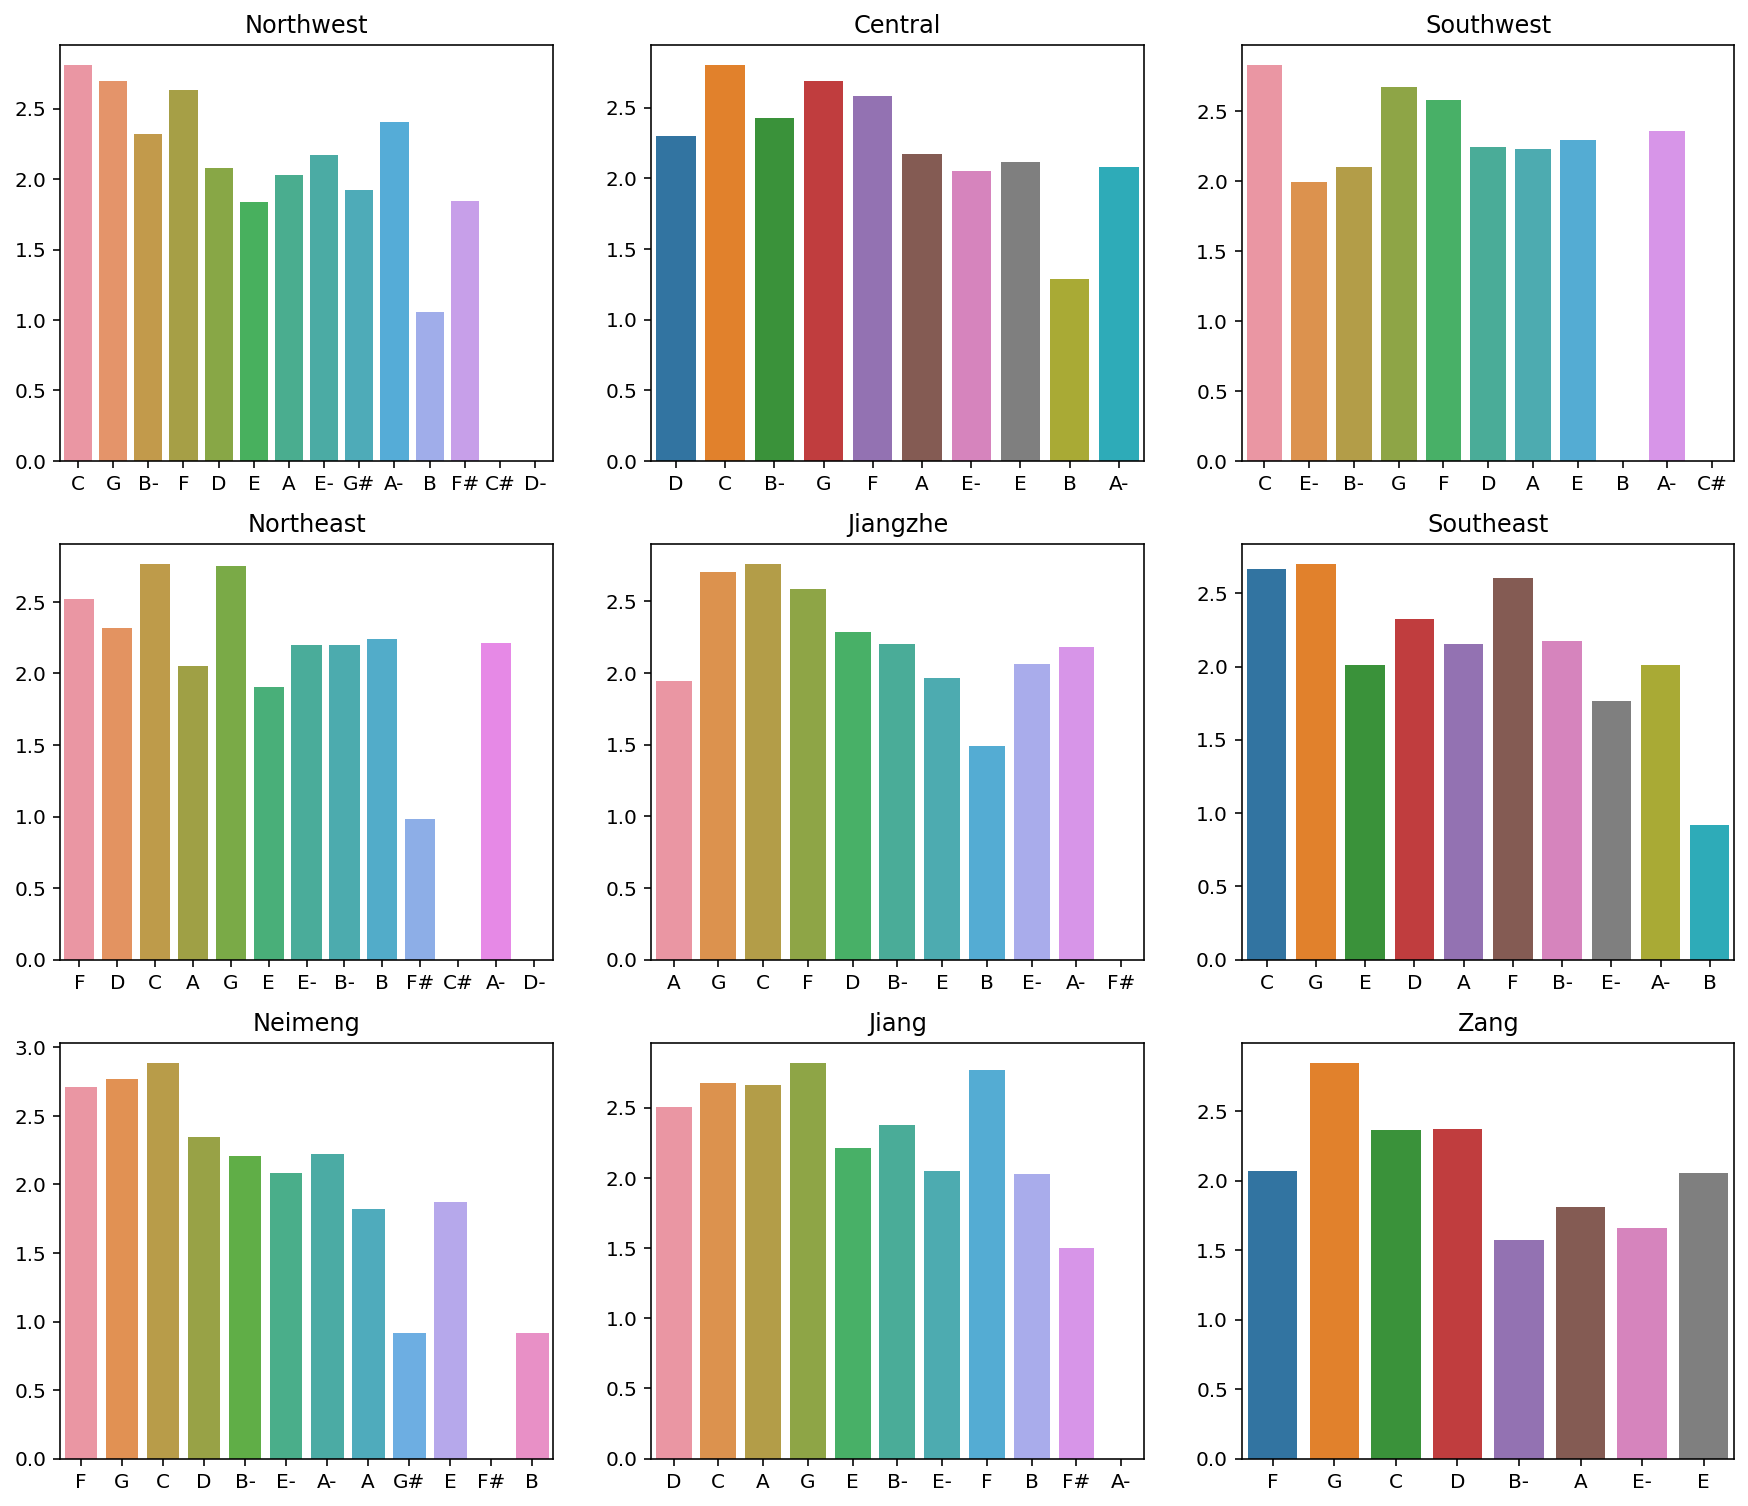

In [50]:
plt.rcParams["figure.figsize"] = (15, 13)
colormap = sns.color_palette("flare", as_cmap=True)
fig, axarr = plt.subplots(3, 3)
for gloc, ax in zip(geo_divisions, axarr.flat):
    ax.set_title(gloc)
    sns.barplot(x=list(entropies[gloc].keys()), y=list(entropies[gloc].values()), ax=ax)

In these results, we can observe that, as in Huron's study, the most central scale degrees also have the highest flexibility, as the dominant, subdominant and second are on the top left in each plot. This results not only shows a similarity between Western and non-Western Folk songs, but also displays great similarity between the CFS of different regions. Therefore, this analysis goes against our hypothesis.

# Stable notes

To investigate the stable notes in each region we perform plain Markovian random walk using the probability transition matrix generated from the pieces of a given geographical division. 

Let A and D be the adjacency and degree matrices of a graph G, respectively. The transition matrix T is defined as $T = D^{-1}A$.
Let $p^{(0)}$ be the state vector (i.e. the i-th component indicates the probability of being at node i) at the beginning of the walk, the first step (walk) can be evaluated as $p^{(1)} = Tp^{(0)}$.

Iteratively, the k-th random walk step can be evaluated as $p^{(k)} = Tp^{(k-1)}$.

In [29]:
def perform_random_walk(transisition_dict, walk_length):
    
    visited = []
    
    graph = nx.DiGraph((k, v, {'weight': weight}) for k, vs in transisition_dict.items() for v, weight in vs.items())
    nodes = list(graph.nodes)
    num_nodes = len(nodes)
    
    # Adjacency matrix
    A = nx.adj_matrix(graph)
    A = A.todense()
    A = np.array(A, dtype = np.float64)
    
    # Degree matrix
    D = np.diag(np.sum(A, axis=0))
    # Transistion matrix
    T = np.dot(np.linalg.inv(D),A)
    # define the starting node, randomly
    empty_state = np.zeros(num_nodes)
    random_node = np.random.randint(low = 0, high = num_nodes-1, size = 1)[0]
    empty_state[random_node] = 1
    p = empty_state.reshape(-1,1)
    
    for k in range(walk_length):
        # next state vector
        p = np.dot(T,p)
        # choose the node with higher probability as the visited node
        visited.append(nodes[np.argmax(p)])
    return visited

In [30]:
print("The average length of piece per region: ")
print(CFS_full.groupby(['geo_division'])['length'].mean())

The average length of piece per region: 
geo_division
Central       76.807143
Jiang        118.800000
Jiangzhe      79.530303
Neimeng       52.028302
Northeast     85.420513
Northwest     49.712670
Southeast     67.598361
Southwest     77.323529
Zang         106.333333
Name: length, dtype: float64


In [51]:
region_avg_piece_length = {"Northwest":50, "Central":77, "Southwest":77, "Northeast":85, "Jiangzhe":80, "Southeast":68, "Neimeng":52, "Jiang":119, "Zang":106}
num_iter = 1000
region_random_walk = {}
exempt_regions = ["Northeast"]
for geo_region in pitchclass_transition_absolute:
    if geo_region not in exempt_regions:
        print("Region Processed: {}".format(geo_region))
        region_random_walk[geo_region] = []
        for _ in range(num_iter):
            region_random_walk[geo_region].extend(perform_random_walk(pitchclass_transition_absolute[geo_region], region_avg_piece_length[geo_region]))
    else:
        print("Region Exempted: {}".format(geo_region))

Region Processed: Northwest
Region Processed: Central
Region Processed: Southwest
Region Exempted: Northeast
Region Processed: Jiangzhe
Region Processed: Southeast
Region Processed: Neimeng
Region Processed: Jiang
Region Processed: Zang


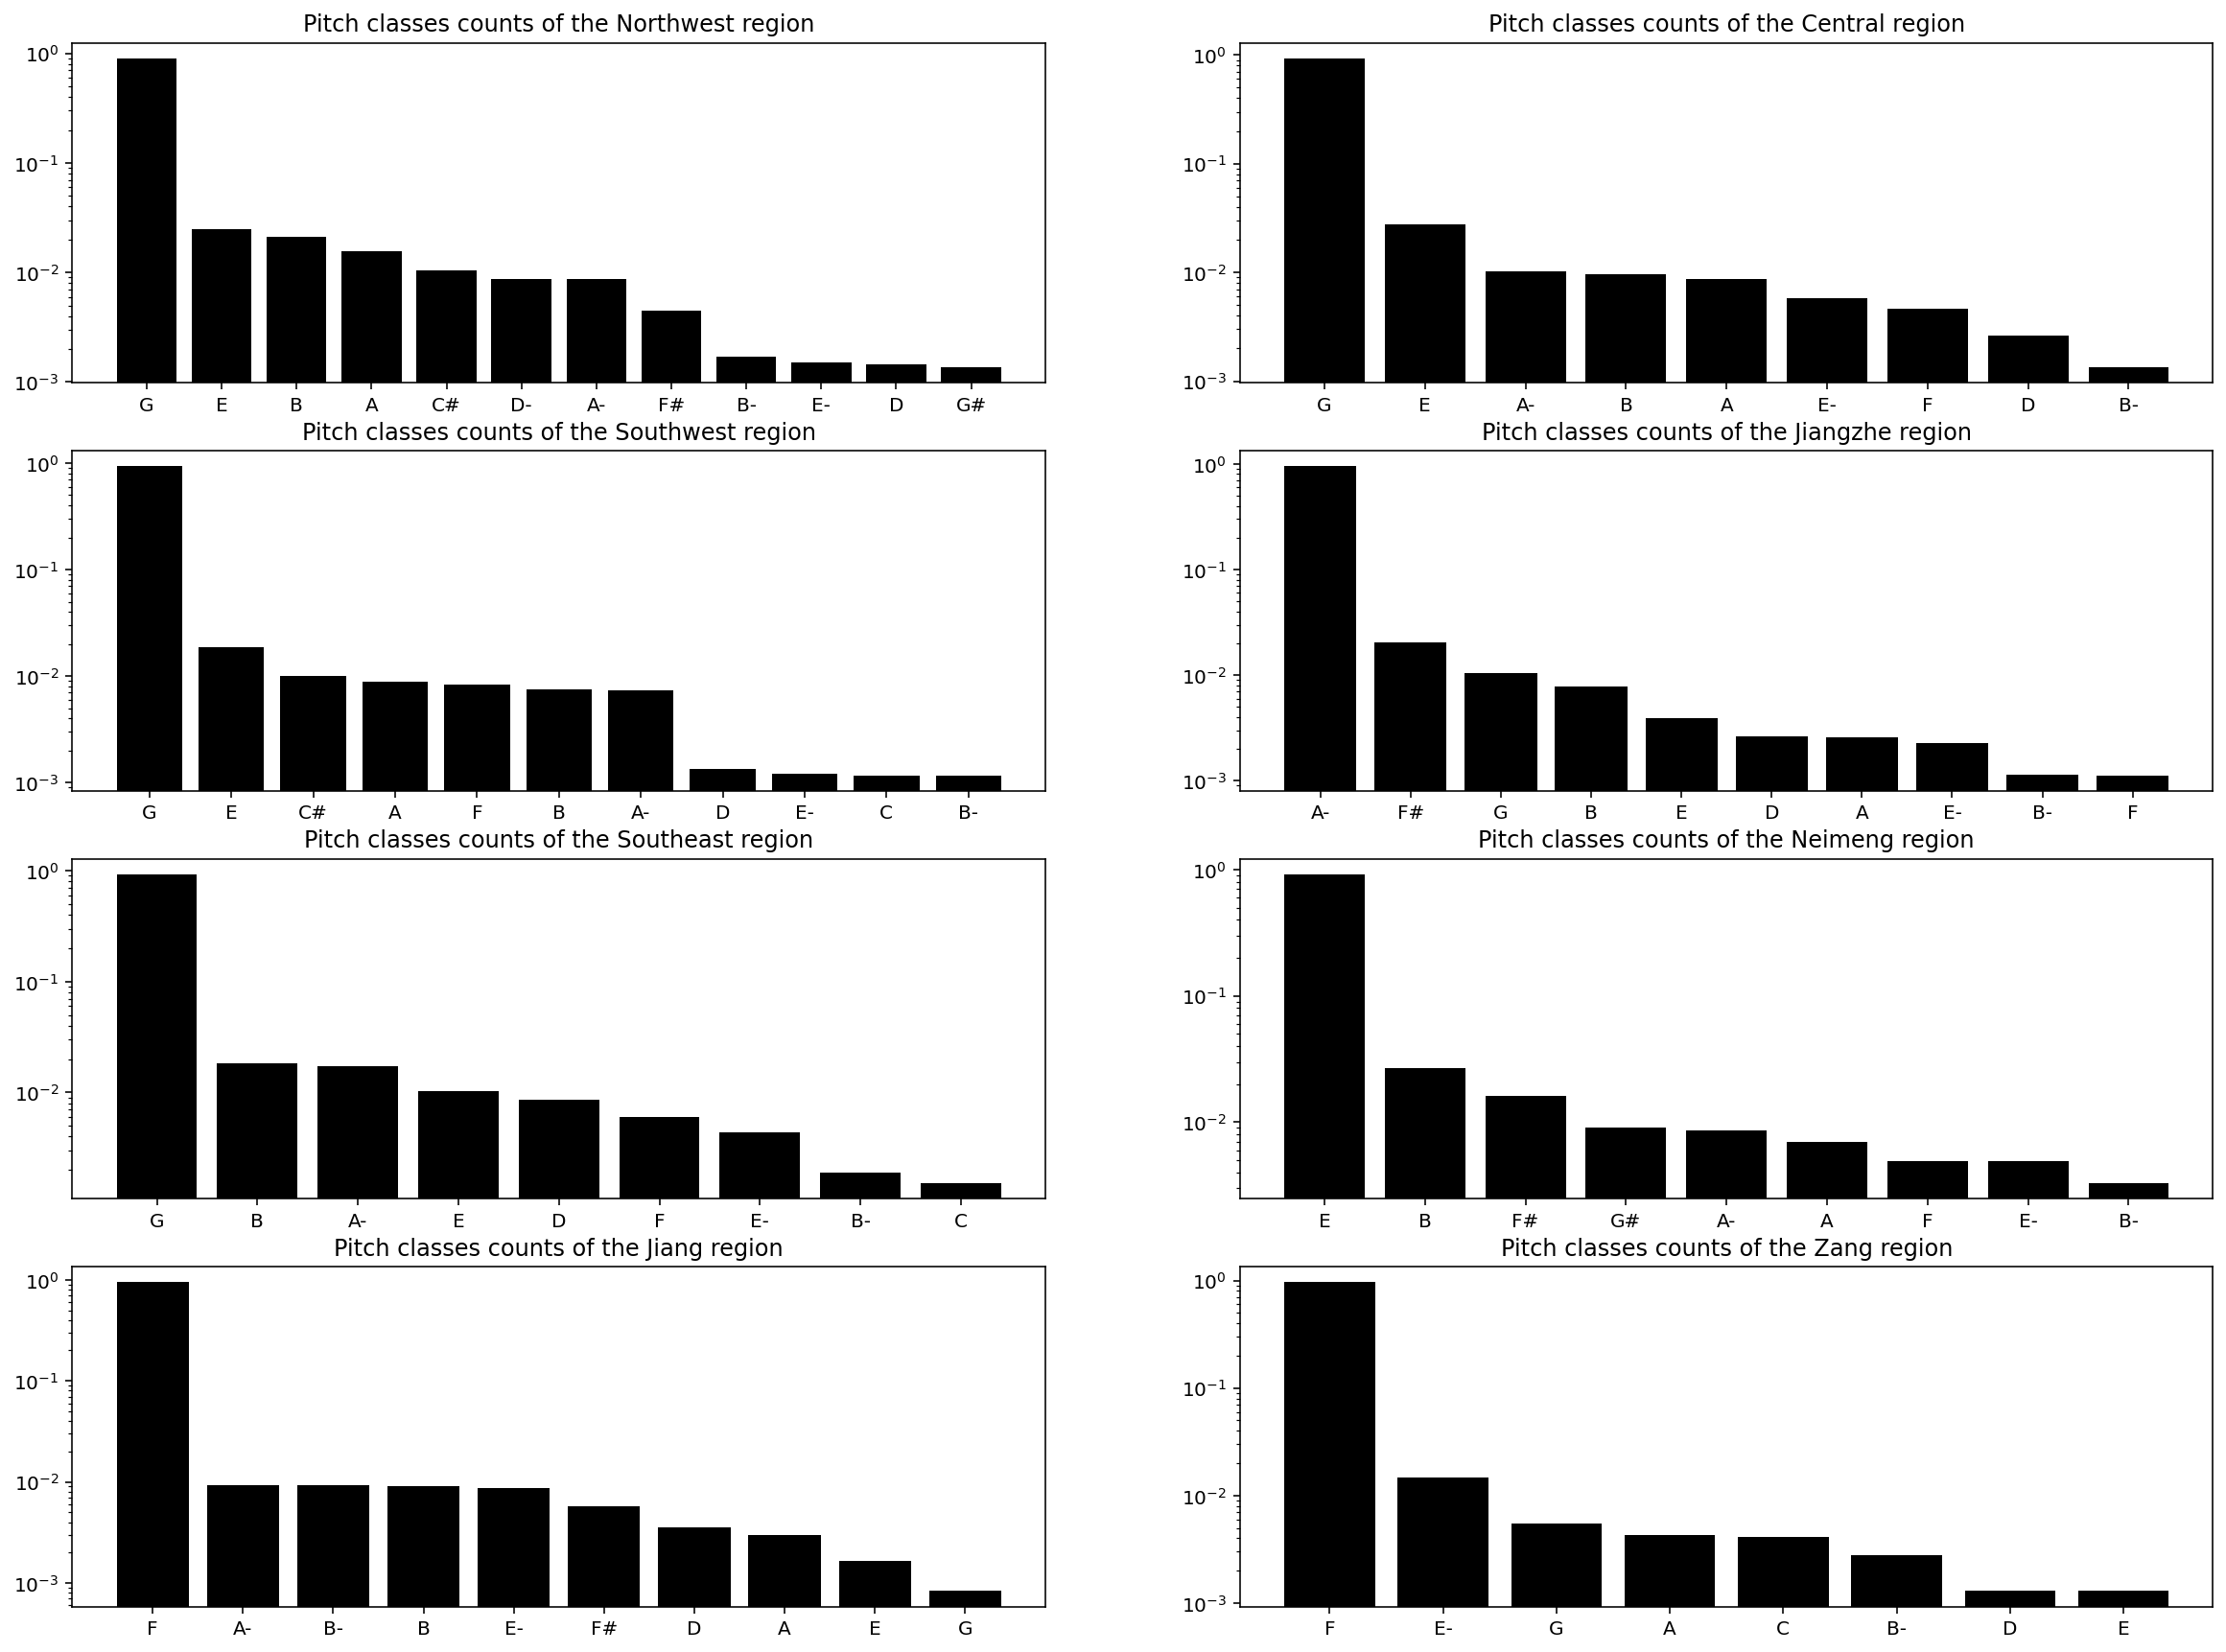

In [52]:
plot_region_stat_counts(region_random_walk, nrows=4, ncols=2, log_y=True, figsize=(20,15), title="Pitch classes counts of the {} region")